In [1]:
import pandas as pd
import numpy as np

### Each simulation uses a separate realization of variable drought sequences over a 100 year simulation period. Some will have fewer or less severe droughts than historically, others will have more.

In [2]:
# Load the data
df = pd.read_csv('Data/DSS_for_Varying_Drought_data.csv', header=[0, 1, 2, 3, 4, 5, 6], index_col=0, parse_dates=True)
# wet_df = pd.read_csv('Data/wet_DSS_for_Varying_Drought_data.csv', header=[0, 1, 2, 3, 4, 5, 6], index_col=0, parse_dates=True)
# dry_df = pd.read_csv('Data/dry_DSS_for_Varying_Drought_data.csv', header=[0, 1, 2, 3, 4, 5, 6], index_col=0, parse_dates=True)
dss_names = pd.read_csv('Data/DSS_for_Varying_Drought_names.csv').drop(['Unnamed: 0'], axis=1)

In [46]:
def add_water_year_column(df):
    df_copy = df.copy()
    df_copy['Date'] = pd.to_datetime(df_copy.index)
    df_copy.loc[:, 'Year'] = df_copy['Date'].dt.year
    df_copy.loc[:, 'Month'] = df_copy['Date'].dt.month
    df_copy.loc[:, 'WaterYear'] = np.where(df_copy['Month'] >= 10, df_copy['Year'] + 1, df_copy['Year'])
    return df_copy.drop(["Date", "Year", "Month"], axis=1)


def create_subset_var(df, varname):
    """ 
    Filters df to return columns that contain the string varname
    :param df: Dataframe to filter
    :param varname: variable of interest, e.g. S_SHSTA
    """
    filtered_columns = df.columns.get_level_values(1).str.contains(varname)
    return df.loc[:, filtered_columns]


def create_subset_unit(df, varname, units):
    """ 
    Filters df to return columns that contain the string varname and units
    :param df: Dataframe to filter
    :param varname: variable of interest, e.g. S_SHSTA
    :param units: units of interest
    """
    var_filter = df.columns.get_level_values(1).str.contains(varname)
    unit_filter = df.columns.get_level_values(6).str.contains(units)
    filtered_columns = var_filter & unit_filter
    return df.loc[:, filtered_columns]


def create_subset_list(df, var_names):
    """ 
    Filters df to return columns that contain any of the strings in var_names.
    :param df: Dataframe to filter.
    :param var_names: List of variables of interest, e.g. ['S_SHSTA', 'S_OROVL'].
    """
    filtered_columns = df.columns.get_level_values(1).str.contains('|'.join(var_names))
    return df.loc[:, filtered_columns]


def compute_annual_means(df, var, units, months):
    subset_df = create_subset_unit(df, var, units)
    subset_df = add_water_year_column(subset_df)

    if months is not None:
        subset_df = subset_df[subset_df.index.month.isin(months)]

    annual_sum = subset_df.groupby('WaterYear').sum()

    return annual_sum


def compute_mean(df, variable_list, units, months=None):
    df = compute_annual_means(df, variable_list, units, months)
    num_years = len(df)
    return (df.sum() / num_years).iloc[-1]


def compute_sd(df, variable_list, units, varname, months=None):
    subset_df = create_subset_unit(df, variable_list, units)
    if months is not None:
        subset_df = subset_df[subset_df.index.month.isin(months)]

    standard_deviation = subset_df.std().to_frame(name=varname).reset_index(drop=True)
    return standard_deviation

In [5]:
def calculate_monthly_average(flow_data):
    flow_data = flow_data.reset_index()
    flow_data['Date'] = pd.to_datetime(flow_data.iloc[:, 0])

    flow_data.loc[:, 'Month'] = flow_data['Date'].dt.strftime('%m')
    flow_data.loc[:, 'Year'] = flow_data['Date'].dt.strftime('%Y')

    flow_values = flow_data.iloc[:, 1:]
    monthly_avg = flow_values.groupby(flow_data['Month']).mean().reset_index()

    monthly_avg.rename(columns={'Month': 'Month'}, inplace=True)
    return monthly_avg


def calculate_flow_sum_per_year(flow_data):
    flow_data = add_water_year_column(flow_data)
    flow_sum_per_year = flow_data.groupby('WaterYear').sum(numeric_only=True).reset_index()

    return flow_sum_per_year

In [6]:
def convert_cfs_to_taf(df):
    date_column = df.index
    months = date_column.strftime('%m')
    years = date_column.strftime('%Y')

    days_in_month = np.zeros(len(df))

    # Compute the number of days in each month, considering leap years for February
    for i in range(len(months)):
        if months[i] in {"01", "03", "05", "07", "08", "10", "12"}:
            days_in_month[i] = 31
        elif months[i] == "02":
            year = int(years[i])
            if year % 4 == 0 and (year % 100 != 0 or year % 400 == 0):
                days_in_month[i] = 29
            else:
                days_in_month[i] = 28
        elif months[i] in {"04", "06", "09", "11"}:
            days_in_month[i] = 30

    columns_to_convert = [col for col in df.columns if ('DEL' in col[1] or 'NDO' in col[1] or 'D_TOTAL' in col[1]) and 'CFS' in col[6]]
    new_columns_dict = {}

    for column in columns_to_convert:
        new_values = df[column].values * 2.29568e-5 * 86400 * days_in_month / 1000
        new_column_name = list(column)
        new_column_name[1] = new_column_name[1] + '_TAF'
        new_column_name[6] = 'TAF'
        new_column_name = tuple(new_column_name)
        new_columns_dict[new_column_name] = new_values

    for new_col, new_values in new_columns_dict.items():
        df[new_col] = new_values

    return df

In [7]:
df = convert_cfs_to_taf(df)

/var/folders/p6/z8ptzv452zz42274h4l4zb4h0000gn/T/ipykernel_59526/1658350417.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = new_values
/var/folders/p6/z8ptzv452zz42274h4l4zb4h0000gn/T/ipykernel_59526/1658350417.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = new_values
/var/folders/p6/z8ptzv452zz42274h4l4zb4h0000gn/T/ipykernel_59526/1658350417.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

### WYType Mapping for Each Simulation

In [8]:
wy_value_map = {
    1: "Wet",
    2: "Wet",
    3: "Wet",
    4: "Dry",
    5: "Dry",
}

In [26]:
def map_water_year(df, simulation):
    df_subset = create_subset_var(df, simulation)
    df_subset = add_water_year_column(df_subset)

    may_values = df_subset[df_subset.index.month == 5].groupby('WaterYear').first()
    wyt_sac_values = may_values[may_values.columns[25]]
    mapped_wyt = wyt_sac_values.map(wy_value_map)

    df_subset = df_subset.assign(WYT_Category=df_subset['WaterYear'].map(mapped_wyt))
    wet_df = df_subset[df_subset['WYT_Category'] == 'Wet']
    dry_df = df_subset[df_subset['WYT_Category'] == 'Dry']
    wet_df = wet_df.drop(columns=['WYT_Category'])
    dry_df = dry_df.drop(columns=['WYT_Category'])

    # Print the count of wet and dry months
    print(f"{simulation} - wet years: {len(wet_df) / 12}, dry years: {len(dry_df) / 12}")

    # Return the DataFrames
    return df_subset, wet_df, dry_df

In [27]:
df_000, wet_df_000, dry_df_000 = map_water_year(df, 'realiz000')
df_001, wet_df_001, dry_df_001 = map_water_year(df, 'realiz001')
df_002, wet_df_002, dry_df_002 = map_water_year(df, 'realiz002')
df_003, wet_df_003, dry_df_003 = map_water_year(df, 'realiz003')
df_004, wet_df_004, dry_df_004 = map_water_year(df, 'realiz004')
df_005, wet_df_005, dry_df_005 = map_water_year(df, 'realiz005')
df_006, wet_df_006, dry_df_006 = map_water_year(df, 'realiz006')
df_007, wet_df_007, dry_df_007 = map_water_year(df, 'realiz007')
df_008, wet_df_008, dry_df_008 = map_water_year(df, 'realiz008')
df_009, wet_df_009, dry_df_009 = map_water_year(df, 'realiz009')

realiz000 - wet years: 64.0, dry years: 36.0
realiz001 - wet years: 52.0, dry years: 48.0
realiz002 - wet years: 55.0, dry years: 45.0
realiz003 - wet years: 60.0, dry years: 40.0
realiz004 - wet years: 72.0, dry years: 28.0
realiz005 - wet years: 63.0, dry years: 37.0
realiz006 - wet years: 71.0, dry years: 29.0
realiz007 - wet years: 79.0, dry years: 21.0
realiz008 - wet years: 70.0, dry years: 30.0
realiz009 - wet years: 60.0, dry years: 40.0


### Redundant code - filters water year type dynamically for each month

In [28]:
# df_000 = create_subset_var(df, 'realiz000')
# wyt_sac_values = df_000[df_000.columns[25]]
# mapped_wyt = wyt_sac_values.map(wy_value_map)
# df_000 = df_000.assign(WYT_Category=mapped_wyt)
# wet_df_000 = df_000[df_000['WYT_Category'] == 'Wet']
# dry_df_000 = df_000[df_000['WYT_Category'] == 'Dry']
# print(f"wet months: {len(wet_df_000)}, dry months: {len(dry_df_000)}")

In [29]:
# df_001 = create_subset_var(df, 'realiz001')
# wyt_sac_values = df_001[df_001.columns[25]]
# mapped_wyt = wyt_sac_values.map(wy_value_map)
# df_001 = df_001.assign(WYT_Category=mapped_wyt)
# wet_df_001 = df_001[df_001['WYT_Category'] == 'Wet']
# dry_df_001 = df_001[df_001['WYT_Category'] == 'Dry']
# print(f"wet months: {len(wet_df_001)}, dry months: {len(dry_df_001)}")

In [30]:
# df_002 = create_subset_var(df, 'realiz002')
# wyt_sac_values = df_002[df_002.columns[25]]
# mapped_wyt = wyt_sac_values.map(wy_value_map)
# df_002 = df_002.assign(WYT_Category=mapped_wyt)
# wet_df_002 = df_002[df_002['WYT_Category'] == 'Wet']
# dry_df_002 = df_002[df_002['WYT_Category'] == 'Dry']
# print(f"wet months: {len(wet_df_002)}, dry months: {len(dry_df_002)}")

In [31]:
# df_003 = create_subset_var(df, 'realiz003')
# wyt_sac_values = df_003[df_003.columns[25]]
# mapped_wyt = wyt_sac_values.map(wy_value_map)
# df_003 = df_003.assign(WYT_Category=mapped_wyt)
# wet_df_003 = df_003[df_003['WYT_Category'] == 'Wet']
# dry_df_003 = df_003[df_003['WYT_Category'] == 'Dry']
# print(f"wet months: {len(wet_df_003)}, dry months: {len(dry_df_003)}")

In [32]:
# df_004 = create_subset_var(df, 'realiz004')
# wyt_sac_values = df_004[df_004.columns[25]]
# mapped_wyt = wyt_sac_values.map(wy_value_map)
# df_004 = df_004.assign(WYT_Category=mapped_wyt)
# wet_df_004 = df_004[df_004['WYT_Category'] == 'Wet']
# dry_df_004 = df_004[df_004['WYT_Category'] == 'Dry']
# print(f"wet months: {len(wet_df_004)}, dry months: {len(dry_df_004)}")

In [33]:
# df_005 = create_subset_var(df, 'realiz005')
# wyt_sac_values = df_005[df_005.columns[25]]
# mapped_wyt = wyt_sac_values.map(wy_value_map)
# df_005 = df_005.assign(WYT_Category=mapped_wyt)
# wet_df_005 = df_005[df_005['WYT_Category'] == 'Wet']
# dry_df_005 = df_005[df_005['WYT_Category'] == 'Dry']
# print(f"wet months: {len(wet_df_005)}, dry months: {len(dry_df_005)}")

In [34]:
# df_006 = create_subset_var(df, 'realiz006')
# wyt_sac_values = df_006[df_006.columns[25]]
# mapped_wyt = wyt_sac_values.map(wy_value_map)
# df_006 = df_006.assign(WYT_Category=mapped_wyt)
# wet_df_006 = df_006[df_006['WYT_Category'] == 'Wet']
# dry_df_006 = df_006[df_006['WYT_Category'] == 'Dry']
# print(f"wet months: {len(wet_df_006)}, dry months: {len(dry_df_006)}")

In [35]:
# df_007 = create_subset_var(df, 'realiz007')
# wyt_sac_values = df_007[df_007.columns[25]]
# mapped_wyt = wyt_sac_values.map(wy_value_map)
# df_007 = df_007.assign(WYT_Category=mapped_wyt)
# wet_df_007 = df_007[df_007['WYT_Category'] == 'Wet']
# dry_df_007 = df_007[df_007['WYT_Category'] == 'Dry']
# print(f"wet months: {len(wet_df_007)}, dry months: {len(dry_df_007)}")

In [36]:
# df_008 = create_subset_var(df, 'realiz008')
# wyt_sac_values = df_008[df_008.columns[25]]
# mapped_wyt = wyt_sac_values.map(wy_value_map)
# df_008 = df_008.assign(WYT_Category=mapped_wyt)
# wet_df_008 = df_008[df_008['WYT_Category'] == 'Wet']
# dry_df_008 = df_008[df_008['WYT_Category'] == 'Dry']
# print(f"wet months: {len(wet_df_008)}, dry months: {len(dry_df_008)}")

In [37]:
# df_009 = create_subset_var(df, 'realiz009')
# wyt_sac_values = df_009[df_009.columns[25]]
# mapped_wyt = wyt_sac_values.map(wy_value_map)
# df_009 = df_009.assign(WYT_Category=mapped_wyt)
# wet_df_009 = df_009[df_009['WYT_Category'] == 'Wet']
# dry_df_009 = df_009[df_009['WYT_Category'] == 'Dry']
# print(f"wet months: {len(wet_df_009)}, dry months: {len(dry_df_009)}")

In [38]:
df_names = [f"df_{i:03}" for i in range(10)]
df_wet_names = [f"wet_df_{i:03}" for i in range(10)]
df_dry_names = [f"dry_df_{i:03}" for i in range(10)]

### Metrics

### DEL CVP PAG N

In [47]:
metrics = []

for df_name in df_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_PAG_N", "TAF", months=None)  
    metrics.append(metric_value)

Ann_Avg_CVP_PAG_N = pd.DataFrame(metrics, columns=['Ann_Avg_CVP_PAG_N'])
Ann_Avg_CVP_PAG_N

,Ann_Avg_CVP_PAG_N
0,298.800468
1,274.062616
2,283.878005
3,303.809253
4,346.021850
5,318.863484
6,331.823182
7,362.100752
8,331.042733
9,281.743301


In [48]:
metrics = []

for df_name in df_wet_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_PAG_N", "TAF", months=None)
    metrics.append(metric_value)

Wet_Ann_Avg_CVP_PAG_N = pd.DataFrame(metrics, columns=['Wet_Ann_Avg_CVP_PAG_N'])
Wet_Ann_Avg_CVP_PAG_N

,Wet_Ann_Avg_CVP_PAG_N
0,385.490618
1,386.316353
2,388.698645
3,390.698626
4,393.975580
5,387.686901
6,396.296992
7,397.793174
8,393.500580
9,390.309863


In [49]:
metrics = []

for df_name in df_dry_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_PAG_N", "TAF", months=None)
    metrics.append(metric_value)
    
Dry_Ann_Avg_CVP_PAG_N = pd.DataFrame(metrics, columns=['Dry_Ann_Avg_CVP_PAG_N'])
Dry_Ann_Avg_CVP_PAG_N

,Dry_Ann_Avg_CVP_PAG_N
0,144.684644
1,152.454400
2,155.763889
3,173.475195
4,222.712260
5,201.677665
6,173.973508
7,227.829258
8,185.307758
9,118.893459


### DEL CVP PAG S

In [50]:
metrics = []

for df_name in df_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_PAG_S", "TAF", months=None)  
    metrics.append(metric_value)
    
Ann_Avg_CVP_PAG_S = pd.DataFrame(metrics, columns=['Ann_Avg_CVP_PAG_S'])
Ann_Avg_CVP_PAG_S

,Ann_Avg_CVP_PAG_S
0,1139.377473
1,989.277535
2,1004.965831
3,1145.080175
4,1272.731864
5,1101.741324
6,1226.767076
7,1369.042783
8,1245.704655
9,1133.965930


In [51]:
metrics = []

for df_name in df_wet_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_PAG_S", "TAF", months=None)
    metrics.append(metric_value)
    
Wet_Ann_Avg_CVP_PAG_S = pd.DataFrame(metrics, columns=['Wet_Ann_Avg_CVP_PAG_S'])
Wet_Ann_Avg_CVP_PAG_S

,Wet_Ann_Avg_CVP_PAG_S
0,1469.420368
1,1433.811503
2,1395.630790
3,1508.935192
4,1474.181679
5,1377.670333
6,1460.239650
7,1514.628226
8,1486.877166
9,1547.416860


In [52]:
metrics = []

for df_name in df_dry_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_PAG_S", "TAF", months=None)
    metrics.append(metric_value)
    
Dry_Ann_Avg_CVP_PAG_S = pd.DataFrame(metrics, columns=['Dry_Ann_Avg_CVP_PAG_S'])
Dry_Ann_Avg_CVP_PAG_S

,Dry_Ann_Avg_CVP_PAG_S
0,552.634547
1,507.699070
2,527.486437
3,599.297650
4,754.718055
5,631.916255
6,655.161811
7,821.364212
8,682.968797
9,513.789536


### DEL CVP PEX S

In [53]:
metrics = []

for df_name in df_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_PEX_S", "TAF", months=None)  
    metrics.append(metric_value)
    
Ann_Avg_CVP_PEX_S = pd.DataFrame(metrics, columns=['Ann_Avg_CVP_PEX_S'])
Ann_Avg_CVP_PEX_S

,Ann_Avg_CVP_PEX_S
0,793.937219
1,799.067682
2,805.364343
3,807.445379
4,810.367425
5,812.008320
6,808.518297
7,809.959992
8,806.828099
9,803.788337


In [54]:
metrics = []

for df_name in df_wet_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_PEX_S", "TAF", months=None)
    metrics.append(metric_value)
    
Wet_Ann_Avg_CVP_PEX_S = pd.DataFrame(metrics, columns=['Wet_Ann_Avg_CVP_PEX_S'])
Wet_Ann_Avg_CVP_PEX_S

,Wet_Ann_Avg_CVP_PEX_S
0,812.290189
1,814.108866
2,816.416164
3,812.545601
4,816.926675
5,815.154924
6,812.285389
7,815.788251
8,814.920082
9,814.013771


In [55]:
metrics = []

for df_name in df_dry_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_PEX_S", "TAF", months=None)
    metrics.append(metric_value)
    
Dry_Ann_Avg_CVP_PEX_S = pd.DataFrame(metrics, columns=['Dry_Ann_Avg_CVP_PEX_S'])
Dry_Ann_Avg_CVP_PEX_S

,Dry_Ann_Avg_CVP_PEX_S
0,761.309716
1,782.773067
2,791.856562
3,799.795046
4,793.500780
5,806.650589
6,799.295417
7,788.034637
8,787.946805
9,788.450185


### DEL CVP PMI N

In [56]:
metrics = []

for df_name in df_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_PMI_N", "TAF", months=None)  
    metrics.append(metric_value)
    
Ann_Avg_CVP_PMI_N = pd.DataFrame(metrics, columns=['Ann_Avg_CVP_PMI_N'])
Ann_Avg_CVP_PMI_N

,Ann_Avg_CVP_PMI_N
0,23.717335
1,23.036867
2,23.454495
3,24.024441
4,24.853416
5,24.335789
6,24.441018
7,25.099443
8,24.445943
9,23.327834


In [57]:
metrics = []

for df_name in df_wet_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_PMI_N", "TAF", months=None)
    metrics.append(metric_value)
    
Wet_Ann_Avg_CVP_PMI_N = pd.DataFrame(metrics, columns=['Wet_Ann_Avg_CVP_PMI_N'])
Wet_Ann_Avg_CVP_PMI_N

,Wet_Ann_Avg_CVP_PMI_N
0,25.220653
1,25.184295
2,25.214869
3,25.378868
4,25.416986
5,25.336588
6,25.382899
7,25.472517
8,25.411791
9,25.261285


In [58]:
metrics = []

for df_name in df_dry_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_PMI_N", "TAF", months=None)
    metrics.append(metric_value)
    
Dry_Ann_Avg_CVP_PMI_N = pd.DataFrame(metrics, columns=['Dry_Ann_Avg_CVP_PMI_N'])
Dry_Ann_Avg_CVP_PMI_N

,Dry_Ann_Avg_CVP_PMI_N
0,21.044770
1,20.710486
2,21.302928
3,21.992801
4,23.404236
5,22.631726
6,22.135034
7,23.695971
8,22.192296
9,20.427657


### DEL CVP PMI S

In [59]:
metrics = []

for df_name in df_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_PMI_S", "TAF", months=None)  
    metrics.append(metric_value)
    
Ann_Avg_CVP_PMI_S = pd.DataFrame(metrics, columns=['Ann_Avg_CVP_PMI_S'])
Ann_Avg_CVP_PMI_S

,Ann_Avg_CVP_PMI_S
0,139.430204
1,131.509932
2,132.361978
3,139.863638
4,146.077612
5,137.190697
6,143.566457
7,149.642220
8,144.052029
9,138.632281


In [60]:
metrics = []

for df_name in df_wet_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_PMI_S", "TAF", months=None)
    metrics.append(metric_value)
    
Wet_Ann_Avg_CVP_PMI_S = pd.DataFrame(metrics, columns=['Wet_Ann_Avg_CVP_PMI_S'])
Wet_Ann_Avg_CVP_PMI_S

,Wet_Ann_Avg_CVP_PMI_S
0,152.071677
1,151.414611
2,148.700362
3,155.292213
4,153.965527
5,148.587328
6,152.685564
7,154.997788
8,154.246979
9,156.336834


In [61]:
metrics = []

for df_name in df_dry_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_PMI_S", "TAF", months=None)
    metrics.append(metric_value)
    
Dry_Ann_Avg_CVP_PMI_S = pd.DataFrame(metrics, columns=['Dry_Ann_Avg_CVP_PMI_S'])
Dry_Ann_Avg_CVP_PMI_S

,Dry_Ann_Avg_CVP_PMI_S
0,116.956474
1,109.946530
2,112.392842
3,116.720775
4,125.794402
5,117.785623
6,121.240367
7,129.495083
8,120.263812
9,112.075451


### DEL CVP PRF N

In [62]:
metrics = []

for df_name in df_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_PRF_N", "TAF", months=None)  
    metrics.append(metric_value)
    
Ann_Avg_CVP_PRF_N = pd.DataFrame(metrics, columns=['Ann_Avg_CVP_PRF_N'])
Ann_Avg_CVP_PRF_N

,Ann_Avg_CVP_PRF_N
0,99.007858
1,98.899010
2,100.434557
3,100.275107
4,100.789536
5,101.335590
6,101.087773
7,100.714144
8,100.477486
9,100.459849


In [63]:
metrics = []

for df_name in df_wet_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_PRF_N", "TAF", months=None)
    metrics.append(metric_value)
    
Wet_Ann_Avg_CVP_PRF_N = pd.DataFrame(metrics, columns=['Wet_Ann_Avg_CVP_PRF_N'])
Wet_Ann_Avg_CVP_PRF_N

,Wet_Ann_Avg_CVP_PRF_N
0,98.878588
1,98.618900
2,99.676873
3,99.199653
4,100.073123
5,99.948058
6,100.342203
7,100.115073
8,100.549134
9,99.472684


In [64]:
metrics = []

for df_name in df_dry_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_PRF_N", "TAF", months=None)
    metrics.append(metric_value)
    
Dry_Ann_Avg_CVP_PRF_N = pd.DataFrame(metrics, columns=['Dry_Ann_Avg_CVP_PRF_N'])
Dry_Ann_Avg_CVP_PRF_N

,Dry_Ann_Avg_CVP_PRF_N
0,99.237671
1,99.202463
2,101.360616
3,101.888288
4,102.631741
5,103.698144
6,102.913135
7,102.967791
8,100.310308
9,101.940596


### DEL CVP PRF S

In [65]:
metrics = []

for df_name in df_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_PRF_S", "TAF", months=None)  
    metrics.append(metric_value)
    
Ann_Avg_CVP_PRF_S = pd.DataFrame(metrics, columns=['Ann_Avg_CVP_PRF_S'])
Ann_Avg_CVP_PRF_S

,Ann_Avg_CVP_PRF_S
0,266.066652
1,266.709783
2,268.810825
3,272.083100
4,272.259267
5,272.445029
6,271.628141
7,272.168085
8,271.217553
9,269.811861


In [66]:
metrics = []

for df_name in df_wet_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_PRF_S", "TAF", months=None)
    metrics.append(metric_value)
    
Wet_Ann_Avg_CVP_PRF_S = pd.DataFrame(metrics, columns=['Wet_Ann_Avg_CVP_PRF_S'])
Wet_Ann_Avg_CVP_PRF_S

,Wet_Ann_Avg_CVP_PRF_S
0,271.705140
1,272.385477
2,270.228533
3,273.709832
4,272.823800
5,272.041331
6,273.050066
7,271.826661
8,273.728407
9,272.150441


In [67]:
metrics = []

for df_name in df_dry_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_PRF_S", "TAF", months=None)
    metrics.append(metric_value)
    
Dry_Ann_Avg_CVP_PRF_S = pd.DataFrame(metrics, columns=['Dry_Ann_Avg_CVP_PRF_S'])
Dry_Ann_Avg_CVP_PRF_S

,Dry_Ann_Avg_CVP_PRF_S
0,256.042675
1,260.561114
2,267.078071
3,269.643001
4,270.807610
5,273.132406
6,268.146878
7,273.452487
8,265.358895
9,266.303992


### DEL CVP PSC N

In [68]:
metrics = []

for df_name in df_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_PSC_N", "TAF", months=None)  
    metrics.append(metric_value)
    
Ann_Avg_CVP_PSC_N = pd.DataFrame(metrics, columns=['Ann_Avg_CVP_PSC_N'])
Ann_Avg_CVP_PSC_N

,Ann_Avg_CVP_PSC_N
0,1508.989315
1,1520.620928
2,1528.942268
3,1525.105199
4,1533.356598
5,1542.431241
6,1532.753265
7,1530.425841
8,1529.708481
9,1537.130114


In [69]:
metrics = []

for df_name in df_wet_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_PSC_N", "TAF", months=None)
    metrics.append(metric_value)
    
Wet_Ann_Avg_CVP_PSC_N = pd.DataFrame(metrics, columns=['Wet_Ann_Avg_CVP_PSC_N'])
Wet_Ann_Avg_CVP_PSC_N

,Wet_Ann_Avg_CVP_PSC_N
0,1526.614858
1,1531.085167
2,1537.312486
3,1517.211656
4,1535.325012
5,1535.304643
6,1529.709421
7,1528.794097
8,1534.650302
9,1534.443647


In [70]:
metrics = []

for df_name in df_dry_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_PSC_N", "TAF", months=None)
    metrics.append(metric_value)
    
Dry_Ann_Avg_CVP_PSC_N = pd.DataFrame(metrics, columns=['Dry_Ann_Avg_CVP_PSC_N'])
Dry_Ann_Avg_CVP_PSC_N

,Dry_Ann_Avg_CVP_PSC_N
0,1477.655017
1,1509.284670
2,1518.712001
3,1536.945513
4,1528.294964
5,1554.565719
6,1540.205436
7,1536.564305
8,1518.177568
9,1541.159816


### DEL CVP TOTAL N

In [71]:
metrics = []

for df_name in df_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_TOTAL_N", "TAF", months=None)  
    metrics.append(metric_value)
    
Ann_Avg_CVP_TOTAL_N = pd.DataFrame(metrics, columns=['Ann_Avg_CVP_TOTAL_N'])
Ann_Avg_CVP_TOTAL_N

,Ann_Avg_CVP_TOTAL_N
0,1930.514978
1,1916.619425
2,1936.709329
3,1953.213999
4,2005.021398
5,1986.966102
6,1990.105241
7,2018.340180
8,1985.674637
9,1942.661094


In [72]:
metrics = []

for df_name in df_wet_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_TOTAL_N", "TAF", months=None)
    metrics.append(metric_value)
    
Wet_Ann_Avg_CVP_TOTAL_N = pd.DataFrame(metrics, columns=['Wet_Ann_Avg_CVP_TOTAL_N'])
Wet_Ann_Avg_CVP_TOTAL_N

,Wet_Ann_Avg_CVP_TOTAL_N
0,2036.204719
1,2041.204721
2,2050.902879
3,2032.488802
4,2054.790696
5,2048.276190
6,2051.731517
7,2052.174862
8,2054.111803
9,2049.487473


In [73]:
metrics = []

for df_name in df_dry_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_TOTAL_N", "TAF", months=None)
    metrics.append(metric_value)
    
Dry_Ann_Avg_CVP_TOTAL_N = pd.DataFrame(metrics, columns=['Dry_Ann_Avg_CVP_TOTAL_N'])
Dry_Ann_Avg_CVP_TOTAL_N

,Dry_Ann_Avg_CVP_TOTAL_N
0,1742.622105
1,1781.652021
2,1797.139436
3,1834.301794
4,1877.043202
5,1882.573248
6,1839.227117
7,1891.057330
8,1825.987917
9,1782.421527


### DEL CVP TOTAL S

In [74]:
metrics = []

for df_name in df_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_TOTAL_S", "TAF", months=None)  
    metrics.append(metric_value)
    
Ann_Avg_CVP_TOTAL_S = pd.DataFrame(metrics, columns=['Ann_Avg_CVP_TOTAL_S'])
Ann_Avg_CVP_TOTAL_S

,Ann_Avg_CVP_TOTAL_S
0,2522.533000
1,2370.286385
2,2395.224436
3,2548.193753
4,2685.157623
5,2507.106823
6,2634.201429
7,2784.534540
8,2651.523788
9,2529.919863


In [75]:
metrics = []

for df_name in df_wet_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_TOTAL_S", "TAF", months=None)
    metrics.append(metric_value)
    
Wet_Ann_Avg_CVP_TOTAL_S = pd.DataFrame(metrics, columns=['Wet_Ann_Avg_CVP_TOTAL_S'])
Wet_Ann_Avg_CVP_TOTAL_S

,Wet_Ann_Avg_CVP_TOTAL_S
0,2889.208826
1,2855.441907
2,2814.697308
3,2934.204300
4,2901.619136
5,2797.175367
6,2881.982129
7,2940.962387
8,2913.494082
9,2973.639354


In [76]:
metrics = []

for df_name in df_dry_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_CVP_TOTAL_S", "TAF", months=None)
    metrics.append(metric_value)
    
Dry_Ann_Avg_CVP_TOTAL_S = pd.DataFrame(metrics, columns=['Dry_Ann_Avg_CVP_TOTAL_S'])
Dry_Ann_Avg_CVP_TOTAL_S

,Dry_Ann_Avg_CVP_TOTAL_S
0,1870.664866
1,1844.701237
2,1882.535371
3,1969.177932
4,2128.542305
5,2013.206329
6,2027.565923
7,2196.067876
8,2040.259769
9,1864.340625


### DEL SWP MWD

In [77]:
metrics = []

for df_name in df_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_SWP_MWD", "TAF", months=None)  
    metrics.append(metric_value)
    
Ann_Avg_SWP_MWD = pd.DataFrame(metrics, columns=['Ann_Avg_SWP_MWD'])
Ann_Avg_SWP_MWD

,Ann_Avg_SWP_MWD
0,984.989542
1,849.255878
2,887.732860
3,1010.031853
4,1053.249992
5,944.496128
6,1017.025632
7,1161.025893
8,1028.423420
9,975.833091


In [78]:
metrics = []

for df_name in df_wet_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_SWP_MWD", "TAF", months=None)
    metrics.append(metric_value)
    
Wet_Ann_Avg_SWP_MWD = pd.DataFrame(metrics, columns=['Wet_Ann_Avg_SWP_MWD'])
Wet_Ann_Avg_SWP_MWD

,Wet_Ann_Avg_SWP_MWD
0,1214.476646
1,1134.289625
2,1136.027484
3,1258.044972
4,1193.381869
5,1152.640608
6,1164.916668
7,1257.942499
8,1198.282307
9,1237.672487


In [79]:
metrics = []

for df_name in df_dry_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_SWP_MWD", "TAF", months=None)
    metrics.append(metric_value)
    
Dry_Ann_Avg_SWP_MWD = pd.DataFrame(metrics, columns=['Dry_Ann_Avg_SWP_MWD'])
Dry_Ann_Avg_SWP_MWD

,Dry_Ann_Avg_SWP_MWD
0,577.012469
1,540.469319
2,584.261653
3,638.012174
4,692.910878
5,590.087961
6,654.947578
7,796.434855
8,632.086017
9,583.073997


### DEL SWP PAG

In [80]:
metrics = []

for df_name in df_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_SWP_PAG", "TAF", months=None)  
    metrics.append(metric_value)
    
Ann_Avg_SWP_PAG = pd.DataFrame(metrics, columns=['Ann_Avg_SWP_PAG'])
Ann_Avg_SWP_PAG

,Ann_Avg_SWP_PAG
0,1282.304484
1,1195.817007
2,1227.047346
3,1284.503494
4,1323.083869
5,1269.143386
6,1304.580041
7,1389.409128
8,1290.059719
9,1271.435988


In [81]:
metrics = []

for df_name in df_wet_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_SWP_PAG", "TAF", months=None)
    metrics.append(metric_value)
    
Wet_Ann_Avg_SWP_PAG = pd.DataFrame(metrics, columns=['Wet_Ann_Avg_SWP_PAG'])
Wet_Ann_Avg_SWP_PAG

,Wet_Ann_Avg_SWP_PAG
0,1445.101974
1,1393.178886
2,1402.470547
3,1460.587683
4,1424.708160
5,1415.101828
6,1413.002005
7,1451.918918
8,1420.382496
9,1454.586765


In [82]:
metrics = []

for df_name in df_dry_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_SWP_PAG", "TAF", months=None)
    metrics.append(metric_value)
    
Dry_Ann_Avg_SWP_PAG = pd.DataFrame(metrics, columns=['Dry_Ann_Avg_SWP_PAG'])
Dry_Ann_Avg_SWP_PAG

,Dry_Ann_Avg_SWP_PAG
0,992.886723
1,982.008305
2,1012.641211
3,1020.377210
4,1061.764265
5,1020.619553
6,1039.133165
7,1154.253249
8,985.973238
9,996.709823


### DEL SWP PMI

In [83]:
metrics = []

for df_name in df_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_SWP_PMI", "TAF", months=None)  
    metrics.append(metric_value)
    
Ann_Avg_SWP_PMI = pd.DataFrame(metrics, columns=['Ann_Avg_SWP_PMI'])
Ann_Avg_SWP_PMI

,Ann_Avg_SWP_PMI
0,1556.390975
1,1359.455460
2,1415.799319
3,1595.465624
4,1668.188020
5,1504.966540
6,1612.287669
7,1820.308445
8,1627.545840
9,1540.743090


In [84]:
metrics = []

for df_name in df_wet_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_SWP_PMI", "TAF", months=None)
    metrics.append(metric_value)

Wet_Ann_Avg_SWP_PMI = pd.DataFrame(metrics, columns=['Wet_Ann_Avg_SWP_PMI'])
Wet_Ann_Avg_SWP_PMI

,Wet_Ann_Avg_SWP_PMI
0,1899.121258
1,1785.540980
2,1791.484329
3,1967.441703
4,1877.550115
5,1819.604806
6,1836.694563
7,1966.733545
8,1879.180355
9,1933.761534


In [85]:
metrics = []

for df_name in df_dry_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "DEL_SWP_PMI", "TAF", months=None)
    metrics.append(metric_value)
    
Dry_Ann_Avg_SWP_PMI = pd.DataFrame(metrics, columns=['Dry_Ann_Avg_SWP_PMI'])
Dry_Ann_Avg_SWP_PMI

,Dry_Ann_Avg_SWP_PMI
0,947.092693
1,897.862813
2,956.628751
3,1037.501505
4,1129.828348
5,969.231115
6,1062.877689
7,1269.471162
8,1040.398638
9,951.215426


### NDO

In [86]:
metrics = []

for df_name in df_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "NDO", "TAF", months=None)  
    metrics.append(metric_value)
    
Ann_Avg_NDO = pd.DataFrame(metrics, columns=['Ann_Avg_NDO'])
Ann_Avg_NDO

,Ann_Avg_NDO
0,15755.920468
1,12388.207069
2,12627.477626
3,15639.765323
4,15333.015992
5,14182.109037
6,15523.090464
7,18333.322916
8,14963.935191
9,14373.457722


In [87]:
metrics = []

for df_name in df_wet_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "NDO", "TAF", months=None)
    metrics.append(metric_value)
    
Wet_Ann_Avg_NDO = pd.DataFrame(metrics, columns=['Wet_Ann_Avg_NDO'])
Wet_Ann_Avg_NDO

,Wet_Ann_Avg_NDO
0,21347.969982
1,18412.592718
2,18222.893698
3,22106.630220
4,18978.461598
5,18816.722587
6,19385.157478
7,21694.999795
8,18828.705876
9,20082.952345


In [88]:
metrics = []

for df_name in df_dry_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "NDO", "TAF", months=None)
    metrics.append(metric_value)
    
Dry_Ann_Avg_NDO = pd.DataFrame(metrics, columns=['Dry_Ann_Avg_NDO'])
Dry_Ann_Avg_NDO

,Dry_Ann_Avg_NDO
0,5814.499110
1,5861.789282
2,5788.635760
3,5939.467976
4,5959.013005
5,6290.740019
6,6067.685016
7,5687.014655
8,5946.136927
9,5809.215788


### S_FOLSM

In [89]:
metrics = []

for df_name in df_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "S_FOLSM", "TAF", months=None)  
    metrics.append(metric_value)
    
Ann_Avg_FOLSM = pd.DataFrame(metrics, columns=['Ann_Avg_FOLSM'])
Ann_Avg_FOLSM

,Ann_Avg_FOLSM
0,7286.341860
1,6979.069969
2,7149.070006
3,7551.774093
4,7774.275343
5,7364.444050
6,7492.354427
7,8023.651441
8,7716.292602
9,7380.091800


In [90]:
metrics = []

for df_name in df_wet_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "S_FOLSM", "TAF", months=None)
    metrics.append(metric_value)
    
Wet_Ann_Avg_FOLSM = pd.DataFrame(metrics, columns=['Wet_Ann_Avg_FOLSM'])
Wet_Ann_Avg_FOLSM

,Wet_Ann_Avg_FOLSM
0,8233.196999
1,8167.088568
2,8163.372221
3,8505.946288
4,8294.420147
5,8243.416161
6,8125.748267
7,8467.402666
8,8439.493192
9,8456.493929


In [91]:
metrics = []

for df_name in df_dry_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "S_FOLSM", "TAF", months=None)
    metrics.append(metric_value)
    
Dry_Ann_Avg_FOLSM = pd.DataFrame(metrics, columns=['Dry_Ann_Avg_FOLSM'])
Dry_Ann_Avg_FOLSM

,Dry_Ann_Avg_FOLSM
0,5603.043836
1,5692.049820
2,5909.367300
3,6120.515800
4,6436.760134
5,5867.815860
6,5941.631574
7,6354.301595
8,6028.824559
9,5765.488606


### S_MELON

In [92]:
metrics = []

for df_name in df_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "S_MELON", "TAF", months=None)  
    metrics.append(metric_value)
    
Ann_Avg_MELON = pd.DataFrame(metrics, columns=['Ann_Avg_MELON'])
Ann_Avg_MELON

,Ann_Avg_MELON
0,18746.065085
1,17646.244375
2,16429.821613
3,19524.117868
4,21211.416924
5,17740.691608
6,20427.788706
7,22446.514183
8,21628.784638
9,20052.005143


In [93]:
metrics = []

for df_name in df_wet_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "S_MELON", "TAF", months=None)
    metrics.append(metric_value)
    
Wet_Ann_Avg_MELON = pd.DataFrame(metrics, columns=['Wet_Ann_Avg_MELON'])
Wet_Ann_Avg_MELON

,Wet_Ann_Avg_MELON
0,20554.519762
1,20124.951226
2,18362.096600
3,21944.006897
4,22289.255828
5,19630.339730
6,21689.761081
7,23033.667586
8,22486.781202
9,22039.036312


In [94]:
metrics = []

for df_name in df_dry_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "S_MELON", "TAF", months=None)
    metrics.append(metric_value)
    
Dry_Ann_Avg_MELON = pd.DataFrame(metrics, columns=['Dry_Ann_Avg_MELON'])
Dry_Ann_Avg_MELON

,Dry_Ann_Avg_MELON
0,15531.034549
1,14960.978620
2,14068.152184
3,15894.284326
4,18439.831172
5,14523.182644
6,17338.132201
7,20237.699003
8,19626.792655
9,17071.458391


### S_MLRTN

In [95]:
metrics = []

for df_name in df_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "S_MLRTN", "TAF", months=None)  
    metrics.append(metric_value)
    
Ann_Avg_MLRTN = pd.DataFrame(metrics, columns=['Ann_Avg_MLRTN'])
Ann_Avg_MLRTN

,Ann_Avg_MLRTN
0,3215.189984
1,3082.120451
2,3048.228936
3,3242.128731
4,3246.407477
5,3130.772213
6,3310.826553
7,3373.115602
8,3231.270630
9,3252.760900


In [96]:
metrics = []

for df_name in df_wet_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "S_MLRTN", "TAF", months=None)
    metrics.append(metric_value)
    
Wet_Ann_Avg_MLRTN = pd.DataFrame(metrics, columns=['Wet_Ann_Avg_MLRTN'])
Wet_Ann_Avg_MLRTN

,Wet_Ann_Avg_MLRTN
0,3562.491512
1,3527.072413
2,3407.122159
3,3662.331311
4,3512.588676
5,3455.787967
6,3565.985442
7,3591.631597
8,3473.157858
9,3657.544548


In [97]:
metrics = []

for df_name in df_dry_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "S_MLRTN", "TAF", months=None)
    metrics.append(metric_value)
    
Dry_Ann_Avg_MLRTN = pd.DataFrame(metrics, columns=['Dry_Ann_Avg_MLRTN'])
Dry_Ann_Avg_MLRTN

,Dry_Ann_Avg_MLRTN
0,2597.765044
1,2600.089160
2,2609.581663
3,2611.824860
4,2561.941538
5,2577.367010
6,2686.127202
7,2551.079238
8,2666.867097
9,2645.585428


### S_OROVL

In [98]:
metrics = []

for df_name in df_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "S_OROVL", "TAF", months=None)  
    metrics.append(metric_value)
    
Ann_Avg_OROVL = pd.DataFrame(metrics, columns=['Ann_Avg_OROVL'])
Ann_Avg_OROVL

,Ann_Avg_OROVL
0,355.2
1,355.2
2,355.2
3,355.2
4,355.2
5,355.2
6,355.2
7,355.2
8,355.2
9,355.2


In [99]:
metrics = []

for df_name in df_wet_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "S_OROVL", "TAF", months=None)
    metrics.append(metric_value)
    
Wet_Ann_Avg_OROVL = pd.DataFrame(metrics, columns=['Wet_Ann_Avg_OROVL'])
Wet_Ann_Avg_OROVL

,Wet_Ann_Avg_OROVL
0,355.2
1,355.2
2,355.2
3,355.2
4,355.2
5,355.2
6,355.2
7,355.2
8,355.2
9,355.2


In [100]:
metrics = []

for df_name in df_dry_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "S_OROVL", "TAF", months=None)
    metrics.append(metric_value)
    
Dry_Ann_Avg_OROVL = pd.DataFrame(metrics, columns=['Dry_Ann_Avg_OROVL'])
Dry_Ann_Avg_OROVL

,Dry_Ann_Avg_OROVL
0,355.2
1,355.2
2,355.2
3,355.2
4,355.2
5,355.2
6,355.2
7,355.2
8,355.2
9,355.2


### S_SHSTA

In [101]:
metrics = []

for df_name in df_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "S_SHSTA", "TAF", months=None)  
    metrics.append(metric_value)
    
Ann_Avg_SHSTA = pd.DataFrame(metrics, columns=['Ann_Avg_SHSTA'])
Ann_Avg_SHSTA

,Ann_Avg_SHSTA
0,46391.698619
1,46629.701022
2,46594.832848
3,46420.345387
4,46401.048528
5,46479.359880
6,46380.872761
7,46250.315734
8,46442.963776
9,46520.530089


In [102]:
metrics = []

for df_name in df_wet_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "S_SHSTA", "TAF", months=None)
    metrics.append(metric_value)
    
Wet_Ann_Avg_SHSTA = pd.DataFrame(metrics, columns=['Wet_Ann_Avg_SHSTA'])
Wet_Ann_Avg_SHSTA

,Wet_Ann_Avg_SHSTA
0,45954.809725
1,46218.166588
2,46165.102862
3,45946.562605
4,46118.270949
5,46142.251689
6,46076.151318
7,46007.474576
8,46148.403066
9,46095.505733


In [103]:
metrics = []

for df_name in df_dry_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "S_SHSTA", "TAF", months=None)
    metrics.append(metric_value)
    
Dry_Ann_Avg_SHSTA = pd.DataFrame(metrics, columns=['Dry_Ann_Avg_SHSTA'])
Dry_Ann_Avg_SHSTA

,Dry_Ann_Avg_SHSTA
0,47168.389986
1,47075.529992
2,47120.058387
3,47131.019560
4,47128.190875
5,47053.354908
6,47126.914914
7,47163.861043
8,47130.272100
9,47158.066623


### S_TRNTY

In [104]:
metrics = []

for df_name in df_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "S_TRNTY", "TAF", months=None)  
    metrics.append(metric_value)
    
Ann_Avg_TRNTY = pd.DataFrame(metrics, columns=['Ann_Avg_TRNTY'])
Ann_Avg_TRNTY

,Ann_Avg_TRNTY
0,2880.0
1,2880.0
2,2880.0
3,2880.0
4,2880.0
5,2880.0
6,2880.0
7,2880.0
8,2880.0
9,2880.0


In [105]:
metrics = []

for df_name in df_wet_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "S_TRNTY", "TAF", months=None)
    metrics.append(metric_value)
    
Wet_Ann_Avg_TRNTY = pd.DataFrame(metrics, columns=['Wet_Ann_Avg_TRNTY'])
Wet_Ann_Avg_TRNTY

,Wet_Ann_Avg_TRNTY
0,2880.0
1,2880.0
2,2880.0
3,2880.0
4,2880.0
5,2880.0
6,2880.0
7,2880.0
8,2880.0
9,2880.0


In [106]:
metrics = []

for df_name in df_dry_names:
    current_df = globals()[df_name]
    metric_value = compute_mean(current_df, "S_TRNTY", "TAF", months=None)
    metrics.append(metric_value)
    
Dry_Ann_Avg_TRNTY = pd.DataFrame(metrics, columns=['Dry_Ann_Avg_TRNTY'])
Dry_Ann_Avg_TRNTY

,Dry_Ann_Avg_TRNTY
0,2880.0
1,2880.0
2,2880.0
3,2880.0
4,2880.0
5,2880.0
6,2880.0
7,2880.0
8,2880.0
9,2880.0


In [107]:
df_metrics = pd.concat([
    Ann_Avg_CVP_PAG_N, Ann_Avg_CVP_PAG_S, Ann_Avg_CVP_PEX_S, Ann_Avg_CVP_PMI_N, Ann_Avg_CVP_PMI_S,
    Ann_Avg_CVP_PRF_N, Ann_Avg_CVP_PRF_S, Ann_Avg_CVP_PSC_N, Ann_Avg_CVP_TOTAL_N, Ann_Avg_CVP_TOTAL_S,
    Ann_Avg_SWP_MWD, Ann_Avg_SWP_PAG, Ann_Avg_SWP_PMI, Ann_Avg_NDO, Ann_Avg_FOLSM, Ann_Avg_MELON,
    Ann_Avg_MLRTN, Ann_Avg_OROVL, Ann_Avg_SHSTA, Ann_Avg_TRNTY], axis=1)
df_metrics

,Ann_Avg_CVP_PAG_N,Ann_Avg_CVP_PAG_S,Ann_Avg_CVP_PEX_S,Ann_Avg_CVP_PMI_N,Ann_Avg_CVP_PMI_S,Ann_Avg_CVP_PRF_N,Ann_Avg_CVP_PRF_S,Ann_Avg_CVP_PSC_N,Ann_Avg_CVP_TOTAL_N,Ann_Avg_CVP_TOTAL_S,Ann_Avg_SWP_MWD,Ann_Avg_SWP_PAG,Ann_Avg_SWP_PMI,Ann_Avg_NDO,Ann_Avg_FOLSM,Ann_Avg_MELON,Ann_Avg_MLRTN,Ann_Avg_OROVL,Ann_Avg_SHSTA,Ann_Avg_TRNTY
0,298.800468,1139.377473,793.937219,23.717335,139.430204,99.007858,266.066652,1508.989315,1930.514978,2522.533000,984.989542,1282.304484,1556.390975,15755.920468,7286.341860,18746.065085,3215.189984,355.2,46391.698619,2880.0
1,274.062616,989.277535,799.067682,23.036867,131.509932,98.899010,266.709783,1520.620928,1916.619425,2370.286385,849.255878,1195.817007,1359.455460,12388.207069,6979.069969,17646.244375,3082.120451,355.2,46629.701022,2880.0
2,283.878005,1004.965831,805.364343,23.454495,132.361978,100.434557,268.810825,1528.942268,1936.709329,2395.224436,887.732860,1227.047346,1415.799319,12627.477626,7149.070006,16429.821613,3048.228936,355.2,46594.832848,2880.0
3,303.809253,1145.080175,807.445379,24.024441,139.863638,100.275107,272.083100,1525.105199,1953.213999,2548.193753,1010.031853,1284.503494,1595.465624,15639.765323,7551.774093,19524.117868,3242.128731,355.2,46420.345387,2880.0
4,346.021850,1272.731864,810.367425,24.853416,146.077612,100.789536,272.259267,1533.356598,2005.021398,2685.157623,1053.249992,1323.083869,1668.188020,15333.015992,7774.275343,21211.416924,3246.407477,355.2,46401.048528,2880.0
5,318.863484,1101.741324,812.008320,24.335789,137.190697,101.335590,272.445029,1542.431241,1986.966102,2507.106823,944.496128,1269.143386,1504.966540,14182.109037,7364.444050,17740.691608,3130.772213,355.2,46479.359880,2880.0
6,331.823182,1226.767076,808.518297,24.441018,143.566457,101.087773,271.628141,1532.753265,1990.105241,2634.201429,1017.025632,1304.580041,1612.287669,15523.090464,7492.354427,20427.788706,3310.826553,355.2,46380.872761,2880.0
7,362.100752,1369.042783,809.959992,25.099443,149.642220,100.714144,272.168085,1530.425841,2018.340180,2784.534540,1161.025893,1389.409128,1820.308445,18333.322916,8023.651441,22446.514183,3373.115602,355.2,46250.315734,2880.0
8,331.042733,1245.704655,806.828099,24.445943,144.052029,100.477486,271.217553,1529.708481,1985.674637,2651.523788,1028.423420,1290.059719,1627.545840,14963.935191,7716.292602,21628.784638,3231.270630,355.2,46442.963776,2880.0
9,281.743301,1133.965930,803.788337,23.327834,138.632281,100.459849,269.811861,1537.130114,1942.661094,2529.919863,975.833091,1271.435988,1540.743090,14373.457722,7380.091800,20052.005143,3252.760900,355.2,46520.530089,2880.0


In [108]:
wet_df_metrics = pd.concat([
    Wet_Ann_Avg_CVP_PAG_N, Wet_Ann_Avg_CVP_PAG_S, Wet_Ann_Avg_CVP_PEX_S, Wet_Ann_Avg_CVP_PMI_N, Wet_Ann_Avg_CVP_PMI_S,
    Wet_Ann_Avg_CVP_PRF_N, Wet_Ann_Avg_CVP_PRF_S, Wet_Ann_Avg_CVP_PSC_N, Wet_Ann_Avg_CVP_TOTAL_N, Wet_Ann_Avg_CVP_TOTAL_S,
    Wet_Ann_Avg_SWP_MWD, Wet_Ann_Avg_SWP_PAG, Wet_Ann_Avg_SWP_PMI, Wet_Ann_Avg_NDO, Wet_Ann_Avg_FOLSM, Wet_Ann_Avg_MELON,
    Wet_Ann_Avg_MLRTN, Wet_Ann_Avg_OROVL, Wet_Ann_Avg_SHSTA, Wet_Ann_Avg_TRNTY], axis=1)
wet_df_metrics

,Wet_Ann_Avg_CVP_PAG_N,Wet_Ann_Avg_CVP_PAG_S,Wet_Ann_Avg_CVP_PEX_S,Wet_Ann_Avg_CVP_PMI_N,Wet_Ann_Avg_CVP_PMI_S,Wet_Ann_Avg_CVP_PRF_N,Wet_Ann_Avg_CVP_PRF_S,Wet_Ann_Avg_CVP_PSC_N,Wet_Ann_Avg_CVP_TOTAL_N,Wet_Ann_Avg_CVP_TOTAL_S,Wet_Ann_Avg_SWP_MWD,Wet_Ann_Avg_SWP_PAG,Wet_Ann_Avg_SWP_PMI,Wet_Ann_Avg_NDO,Wet_Ann_Avg_FOLSM,Wet_Ann_Avg_MELON,Wet_Ann_Avg_MLRTN,Wet_Ann_Avg_OROVL,Wet_Ann_Avg_SHSTA,Wet_Ann_Avg_TRNTY
0,385.490618,1469.420368,812.290189,25.220653,152.071677,98.878588,271.705140,1526.614858,2036.204719,2889.208826,1214.476646,1445.101974,1899.121258,21347.969982,8233.196999,20554.519762,3562.491512,355.2,45954.809725,2880.0
1,386.316353,1433.811503,814.108866,25.184295,151.414611,98.618900,272.385477,1531.085167,2041.204721,2855.441907,1134.289625,1393.178886,1785.540980,18412.592718,8167.088568,20124.951226,3527.072413,355.2,46218.166588,2880.0
2,388.698645,1395.630790,816.416164,25.214869,148.700362,99.676873,270.228533,1537.312486,2050.902879,2814.697308,1136.027484,1402.470547,1791.484329,18222.893698,8163.372221,18362.096600,3407.122159,355.2,46165.102862,2880.0
3,390.698626,1508.935192,812.545601,25.378868,155.292213,99.199653,273.709832,1517.211656,2032.488802,2934.204300,1258.044972,1460.587683,1967.441703,22106.630220,8505.946288,21944.006897,3662.331311,355.2,45946.562605,2880.0
4,393.975580,1474.181679,816.926675,25.416986,153.965527,100.073123,272.823800,1535.325012,2054.790696,2901.619136,1193.381869,1424.708160,1877.550115,18978.461598,8294.420147,22289.255828,3512.588676,355.2,46118.270949,2880.0
5,387.686901,1377.670333,815.154924,25.336588,148.587328,99.948058,272.041331,1535.304643,2048.276190,2797.175367,1152.640608,1415.101828,1819.604806,18816.722587,8243.416161,19630.339730,3455.787967,355.2,46142.251689,2880.0
6,396.296992,1460.239650,812.285389,25.382899,152.685564,100.342203,273.050066,1529.709421,2051.731517,2881.982129,1164.916668,1413.002005,1836.694563,19385.157478,8125.748267,21689.761081,3565.985442,355.2,46076.151318,2880.0
7,397.793174,1514.628226,815.788251,25.472517,154.997788,100.115073,271.826661,1528.794097,2052.174862,2940.962387,1257.942499,1451.918918,1966.733545,21694.999795,8467.402666,23033.667586,3591.631597,355.2,46007.474576,2880.0
8,393.500580,1486.877166,814.920082,25.411791,154.246979,100.549134,273.728407,1534.650302,2054.111803,2913.494082,1198.282307,1420.382496,1879.180355,18828.705876,8439.493192,22486.781202,3473.157858,355.2,46148.403066,2880.0
9,390.309863,1547.416860,814.013771,25.261285,156.336834,99.472684,272.150441,1534.443647,2049.487473,2973.639354,1237.672487,1454.586765,1933.761534,20082.952345,8456.493929,22039.036312,3657.544548,355.2,46095.505733,2880.0


In [109]:
dry_df_metrics = pd.concat([
    Dry_Ann_Avg_CVP_PAG_N, Dry_Ann_Avg_CVP_PAG_S, Dry_Ann_Avg_CVP_PEX_S, Dry_Ann_Avg_CVP_PMI_N, Dry_Ann_Avg_CVP_PMI_S,
    Dry_Ann_Avg_CVP_PRF_N, Dry_Ann_Avg_CVP_PRF_S, Dry_Ann_Avg_CVP_PSC_N, Dry_Ann_Avg_CVP_TOTAL_N, Dry_Ann_Avg_CVP_TOTAL_S,
    Dry_Ann_Avg_SWP_MWD, Dry_Ann_Avg_SWP_PAG, Dry_Ann_Avg_SWP_PMI, Dry_Ann_Avg_NDO, Dry_Ann_Avg_FOLSM, Dry_Ann_Avg_MELON,
    Dry_Ann_Avg_MLRTN, Dry_Ann_Avg_OROVL, Dry_Ann_Avg_SHSTA, Dry_Ann_Avg_TRNTY], axis=1)
dry_df_metrics

,Dry_Ann_Avg_CVP_PAG_N,Dry_Ann_Avg_CVP_PAG_S,Dry_Ann_Avg_CVP_PEX_S,Dry_Ann_Avg_CVP_PMI_N,Dry_Ann_Avg_CVP_PMI_S,Dry_Ann_Avg_CVP_PRF_N,Dry_Ann_Avg_CVP_PRF_S,Dry_Ann_Avg_CVP_PSC_N,Dry_Ann_Avg_CVP_TOTAL_N,Dry_Ann_Avg_CVP_TOTAL_S,Dry_Ann_Avg_SWP_MWD,Dry_Ann_Avg_SWP_PAG,Dry_Ann_Avg_SWP_PMI,Dry_Ann_Avg_NDO,Dry_Ann_Avg_FOLSM,Dry_Ann_Avg_MELON,Dry_Ann_Avg_MLRTN,Dry_Ann_Avg_OROVL,Dry_Ann_Avg_SHSTA,Dry_Ann_Avg_TRNTY
0,144.684644,552.634547,761.309716,21.044770,116.956474,99.237671,256.042675,1477.655017,1742.622105,1870.664866,577.012469,992.886723,947.092693,5814.499110,5603.043836,15531.034549,2597.765044,355.2,47168.389986,2880.0
1,152.454400,507.699070,782.773067,20.710486,109.946530,99.202463,260.561114,1509.284670,1781.652021,1844.701237,540.469319,982.008305,897.862813,5861.789282,5692.049820,14960.978620,2600.089160,355.2,47075.529992,2880.0
2,155.763889,527.486437,791.856562,21.302928,112.392842,101.360616,267.078071,1518.712001,1797.139436,1882.535371,584.261653,1012.641211,956.628751,5788.635760,5909.367300,14068.152184,2609.581663,355.2,47120.058387,2880.0
3,173.475195,599.297650,799.795046,21.992801,116.720775,101.888288,269.643001,1536.945513,1834.301794,1969.177932,638.012174,1020.377210,1037.501505,5939.467976,6120.515800,15894.284326,2611.824860,355.2,47131.019560,2880.0
4,222.712260,754.718055,793.500780,23.404236,125.794402,102.631741,270.807610,1528.294964,1877.043202,2128.542305,692.910878,1061.764265,1129.828348,5959.013005,6436.760134,18439.831172,2561.941538,355.2,47128.190875,2880.0
5,201.677665,631.916255,806.650589,22.631726,117.785623,103.698144,273.132406,1554.565719,1882.573248,2013.206329,590.087961,1020.619553,969.231115,6290.740019,5867.815860,14523.182644,2577.367010,355.2,47053.354908,2880.0
6,173.973508,655.161811,799.295417,22.135034,121.240367,102.913135,268.146878,1540.205436,1839.227117,2027.565923,654.947578,1039.133165,1062.877689,6067.685016,5941.631574,17338.132201,2686.127202,355.2,47126.914914,2880.0
7,227.829258,821.364212,788.034637,23.695971,129.495083,102.967791,273.452487,1536.564305,1891.057330,2196.067876,796.434855,1154.253249,1269.471162,5687.014655,6354.301595,20237.699003,2551.079238,355.2,47163.861043,2880.0
8,185.307758,682.968797,787.946805,22.192296,120.263812,100.310308,265.358895,1518.177568,1825.987917,2040.259769,632.086017,985.973238,1040.398638,5946.136927,6028.824559,19626.792655,2666.867097,355.2,47130.272100,2880.0
9,118.893459,513.789536,788.450185,20.427657,112.075451,101.940596,266.303992,1541.159816,1782.421527,1864.340625,583.073997,996.709823,951.215426,5809.215788,5765.488606,17071.458391,2645.585428,355.2,47158.066623,2880.0


### Parallel Plots

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from pandas.plotting import parallel_coordinates

In [111]:
figsize = (18,6)
fontsize = 14
output_data_dir = "Figures/EDA"

In [112]:
### function to normalize data based on direction of preference and whether each objective is minimized or maximized
###   -> output dataframe will have values ranging from 0 (which maps to bottom of figure) to 1 (which maps to top)
def reorganize_objs(objs, columns_axes, ideal_direction, minmaxs):
    ### if min/max directions not given for each axis, assume all should be maximized
    if minmaxs is None:
        minmaxs = ['max'] * len(columns_axes)

    ### get subset of dataframe columns that will be shown as parallel axes
    objs_reorg = objs[columns_axes]

    ### reorganize & normalize data to go from 0 (bottom of figure) to 1 (top of figure), 
    ### based on direction of preference for figure and individual axes
    if ideal_direction == 'bottom':
        tops = objs_reorg.min(axis=0)
        bottoms = objs_reorg.max(axis=0)
        for i, minmax in enumerate(minmaxs):
            if minmax == 'max':
                objs_reorg.iloc[:, i] = (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i]) / \
                                        (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i].min(axis=0))
            else:
                bottoms[i], tops[i] = tops[i], bottoms[i]
                objs_reorg.iloc[:, -1] = (objs_reorg.iloc[:, -1] - objs_reorg.iloc[:, -1].min(axis=0)) / \
                                         (objs_reorg.iloc[:, -1].max(axis=0) - objs_reorg.iloc[:, -1].min(axis=0))
    elif ideal_direction == 'top':
        tops = objs_reorg.max(axis=0)
        bottoms = objs_reorg.min(axis=0)
        for i, minmax in enumerate(minmaxs):
            if minmax == 'max':
                objs_reorg.iloc[:, i] = (objs_reorg.iloc[:, i] - objs_reorg.iloc[:, i].min(axis=0)) / \
                                        (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i].min(axis=0))
            else:
                bottoms[i], tops[i] = tops[i], bottoms[i]
                objs_reorg.iloc[:, i] = (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i]) / \
                                        (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i].min(axis=0))

    return objs_reorg, tops, bottoms


### function to get color based on continuous color map or categorical map
def get_color(value, color_by_continuous, color_palette_continuous,
              color_by_categorical, color_dict_categorical):
    if color_by_continuous is not None:
        color = plt.get_cmap(color_palette_continuous)(value)
    elif color_by_categorical is not None:
        color = color_dict_categorical[value]
    return color


### function to get zorder value for ordering lines on plot. 
### This works by binning a given axis' values and mapping to discrete classes.
def get_zorder(norm_value, zorder_num_classes, zorder_direction):
    xgrid = np.arange(0, 1.001, 1 / zorder_num_classes)
    if zorder_direction == 'ascending':
        return 4 + np.sum(norm_value > xgrid)
    elif zorder_direction == 'descending':
        return 4 + np.sum(norm_value < xgrid)

In [113]:
def custom_parallel_coordinates(objs, columns_axes=None, axis_labels=None, ideal_direction='top', minmaxs=None, color_by_continuous=None, color_palette_continuous=None, color_by_categorical=None, color_palette_categorical=None, colorbar_ticks_continuous=None, color_dict_categorical=None, zorder_by=None, zorder_num_classes=10, zorder_direction='ascending', alpha_base=0.8, brushing_dict=None, alpha_brush=0.05, lw_base=1.5, fontsize=14, figsize=(11,6), save_fig_filename=None):
    """
    Parameters:
    objs (DataFrame): The DataFrame containing the data to plot.
    columns_axes (list, optional): List of column names to use as axes. Defaults to all columns.
    axis_labels (list, optional): List of axis labels. Defaults to the same as columns_axes.
    ideal_direction (str, optional): Direction of preference for objective values. Can be 'top' or 'bottom'. Defaults to 'top'.
    minmaxs (list, optional): List of 'max' or 'min' for each column, indicating if higher or lower values are better.
    color_by_continuous (str, optional): Column name to color lines by continuous values. Cannot be used with color_by_categorical.
    color_palette_continuous (Colormap, optional): Colormap to use for continuous coloring.
    color_by_categorical (str, optional): Column name to color lines by categorical values. Cannot be used with color_by_continuous.
    color_palette_categorical (list, optional): List of colors to use for categorical coloring.
    colorbar_ticks_continuous (list, optional): List of tick values for the continuous colorbar.
    color_dict_categorical (dict, optional): Dictionary mapping categorical values to colors.
    zorder_by (str, optional): Column name to determine the z-order (layer) of the lines.
    zorder_num_classes (int, optional): Number of classes for z-ordering. Defaults to 10.
    zorder_direction (str, optional): Direction for z-ordering. Can be 'ascending' or 'descending'. Defaults to 'ascending'.
    alpha_base (float, optional): Base alpha (transparency) value for the lines. Defaults to 0.8.
    brushing_dict (dict, optional): Dictionary specifying brushing criteria in the form {column_index: (threshold, operator)}.
    alpha_brush (float, optional): Alpha value for lines that do not meet brushing criteria. Defaults to 0.05.
    lw_base (float, optional): Baseline width for the lines. Defaults to 1.5.
    fontsize (int, optional): Font size for the labels and annotations. Defaults to 14.
    figsize (tuple, optional): Size of the figure in inches. Defaults to (11, 6).
    save_fig_filename (str, optional): Filename to save the figure. If None, the figure is not saved. Defaults to None.
    """

    ### verify that all inputs take supported values
    assert ideal_direction in ['top','bottom']
    assert zorder_direction in ['ascending', 'descending']
    if minmaxs is not None:
        for minmax in minmaxs:
            assert minmax in ['max','min']
    assert color_by_continuous is None or color_by_categorical is None
    if columns_axes is None:
        columns_axes = objs.columns
    if axis_labels is None:
        #axis_labels = columns_axes ## <--- column_axes is not defined? Ask about this (Axis labels have to be defined)
        axis_labels = columns_axes

    ### create figure
    fig,ax = plt.subplots(1,1,figsize=figsize, gridspec_kw={'hspace':0.1, 'wspace':0.1})

    ### reorganize & normalize objective data
    objs_reorg, tops, bottoms = reorganize_objs(objs, columns_axes, ideal_direction, minmaxs)

    ### apply any brushing criteria
    if brushing_dict is not None:
        satisfice = np.zeros(objs.shape[0]) == 0.
        ### iteratively apply all brushing criteria to get satisficing set of solutions
        for col_idx, (threshold, operator) in brushing_dict.items():
            if operator == '<':
                satisfice = np.logical_and(satisfice, objs.iloc[:,col_idx] < threshold)
            elif operator == '<=':
                satisfice = np.logical_and(satisfice, objs.iloc[:,col_idx] <= threshold)
            elif operator == '>':
                satisfice = np.logical_and(satisfice, objs.iloc[:,col_idx] > threshold)
            elif operator == '>=':
                satisfice = np.logical_and(satisfice, objs.iloc[:,col_idx] >= threshold)

            ### add rectangle patch to plot to represent brushing
            threshold_norm = (threshold - bottoms[col_idx]) / (tops[col_idx] - bottoms[col_idx])
            if ideal_direction == 'top' and minmaxs[col_idx] == 'max':
                if operator in ['<', '<=']:
                    rect = Rectangle([col_idx-0.05, threshold_norm], 0.1, 1-threshold_norm)
                elif operator in ['>', '>=']:
                    rect = Rectangle([col_idx-0.05, 0], 0.1, threshold_norm)
            elif ideal_direction == 'top' and minmaxs[col_idx] == 'min':
                if operator in ['<', '<=']:
                    rect = Rectangle([col_idx-0.05, 0], 0.1, threshold_norm)
                elif operator in ['>', '>=']:
                    rect = Rectangle([col_idx-0.05, threshold_norm], 0.1, 1-threshold_norm)
            if ideal_direction == 'bottom' and minmaxs[col_idx] == 'max':
                if operator in ['<', '<=']:
                    rect = Rectangle([col_idx-0.05, 0], 0.1, threshold_norm)
                elif operator in ['>', '>=']:
                    rect = Rectangle([col_idx-0.05, threshold_norm], 0.1, 1-threshold_norm)
            elif ideal_direction == 'bottom' and minmaxs[col_idx] == 'min':
                if operator in ['<', '<=']:
                    rect = Rectangle([col_idx-0.05, threshold_norm], 0.1, 1-threshold_norm)
                elif operator in ['>', '>=']:
                    rect = Rectangle([col_idx-0.05, 0], 0.1, threshold_norm)

            pc = PatchCollection([rect], facecolor='grey', alpha=0.5, zorder=3)
            ax.add_collection(pc)

    ### loop over all solutions/rows & plot on parallel axis plot
    for i in range(objs_reorg.shape[0]):
        if color_by_continuous is not None:
            color = get_color(objs_reorg[columns_axes[color_by_continuous]].iloc[i],
                              color_by_continuous, color_palette_continuous,
                              color_by_categorical, color_dict_categorical)
        elif color_by_categorical is not None:
            color = get_color(objs[color_by_categorical].iloc[i],
                              color_by_continuous, color_palette_continuous,
                              color_by_categorical, color_dict_categorical)

        ### order lines according to ascending or descending values of one of the objectives?
        if zorder_by is None:
            zorder = 4
        else:
            zorder = get_zorder(objs_reorg[columns_axes[zorder_by]].iloc[i],
                                zorder_num_classes, zorder_direction)

        ### apply any brushing?
        if brushing_dict is not None:
            if satisfice.iloc[i]:
                alpha = alpha_base
                lw = lw_base
            else:
                alpha = alpha_brush
                lw = 1
                zorder = 2
        else:
            alpha = alpha_base
            lw = lw_base

        ## loop over objective/column pairs & plot lines between parallel axes
        for j in range(objs_reorg.shape[1]-1):
            y = [objs_reorg.iloc[i, j], objs_reorg.iloc[i, j+1]]
            x = [j, j+1]
            ax.plot(x, y, c=color, alpha=alpha, zorder=zorder, lw=lw)

    ### add top/bottom ranges
    for j in range(len(columns_axes)):
        ax.annotate(str(round(tops[j])), [j, 1.02], ha='center', va='bottom',
                    zorder=5, fontsize=fontsize)
        if j == len(columns_axes)-1:
            ax.annotate(str(round(bottoms[j])) + '+', [j, -0.02], ha='center', va='top',
                        zorder=5, fontsize=fontsize)
        else:
            ax.annotate(str(round(bottoms[j])), [j, -0.02], ha='center', va='top',
                        zorder=5, fontsize=fontsize)

        ax.plot([j,j], [0,1], c='k', zorder=1)

    ### other aesthetics
    ax.set_xticks([])
    ax.set_yticks([])

    for spine in ['top','bottom','left','right']:
        ax.spines[spine].set_visible(False)

    if ideal_direction == 'top':
        ax.arrow(-0.15,0.1,0,0.7, head_width=0.08, head_length=0.05, color='k', lw=1.5)
    elif ideal_direction == 'bottom':
        ax.arrow(-0.15,0.9,0,-0.7, head_width=0.08, head_length=0.05, color='k', lw=1.5)
    ax.annotate('Direction of preference', xy=(-0.3,0.5), ha='center', va='center',
                rotation=90, fontsize=fontsize)

    #ax.set_xlim(-0.4, 4.2) # REASON WHY ONLY 5 VARS
    ax.set_xlim(-0.4, len(columns_axes) - 0.6)
    ax.set_ylim(-0.4,1.1)

    for i,l in enumerate(axis_labels):
        ax.annotate(l, xy=(i,-0.12), ha='center', va='top', fontsize=fontsize)
    ax.patch.set_alpha(0)


    ### colorbar for continuous legend
    if color_by_continuous is not None:
        mappable = cm.ScalarMappable(cmap=color_palette_continuous)
        mappable.set_clim(vmin=objs[columns_axes[color_by_continuous]].min(),
                          vmax=objs[columns_axes[color_by_continuous]].max())
        cb = plt.colorbar(mappable, ax=ax, orientation='horizontal', shrink=0.4,
                          label=axis_labels[color_by_continuous], pad=0.03,
                          alpha=alpha_base)
        if colorbar_ticks_continuous is not None:
            _ = cb.ax.set_xticks(colorbar_ticks_continuous, colorbar_ticks_continuous,
                                 fontsize=fontsize)
        _ = cb.ax.set_xlabel(cb.ax.get_xlabel(), fontsize=fontsize)
        ### categorical legend
    elif color_by_categorical is not None:
        leg = []
        for label,color in color_dict_categorical.items():
            leg.append(Line2D([0], [0], color=color, lw=3,
                              alpha=alpha_base, label=label))
        _ = ax.legend(handles=leg, loc='lower center',
                      ncol=max(3, len(color_dict_categorical)),
                      bbox_to_anchor=[0.5,-0.07], frameon=False, fontsize=fontsize)

    ### save figure
    if save_fig_filename is not None:
        plt.savefig(save_fig_filename, bbox_inches='tight', transparent=True, dpi=600)

In [114]:
color_dict_categorical = {
    0: 'firebrick',
    1: 'goldenrod',
    2: 'cornflowerblue',
    3: 'forestgreen',
    4: 'mediumpurple',
    5: 'darkorange',
    6: 'deepskyblue',
    7: 'orchid',
    8: 'sienna',
    9: 'slategray'
}

### Storage Variables

In [122]:
df_metrics_storage = df_metrics[["Ann_Avg_FOLSM", "Ann_Avg_MELON", "Ann_Avg_MLRTN", "Ann_Avg_OROVL", "Ann_Avg_SHSTA", "Ann_Avg_TRNTY"]]
df_metrics_storage["Simulation"] = df_metrics_storage.index

wet_metrics_storage = wet_df_metrics[["Wet_Ann_Avg_FOLSM", "Wet_Ann_Avg_MELON", "Wet_Ann_Avg_MLRTN", "Wet_Ann_Avg_OROVL", "Wet_Ann_Avg_SHSTA", "Wet_Ann_Avg_TRNTY"]]
wet_metrics_storage["Simulation"] = wet_metrics_storage.index

dry_metrics_storage = dry_df_metrics[["Dry_Ann_Avg_FOLSM", "Dry_Ann_Avg_MELON", "Dry_Ann_Avg_MLRTN", "Dry_Ann_Avg_OROVL", "Dry_Ann_Avg_SHSTA", "Dry_Ann_Avg_TRNTY"]]
dry_metrics_storage["Simulation"] = dry_metrics_storage.index

/var/folders/p6/z8ptzv452zz42274h4l4zb4h0000gn/T/ipykernel_59526/296909053.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metrics_storage["Simulation"] = df_metrics_storage.index
/var/folders/p6/z8ptzv452zz42274h4l4zb4h0000gn/T/ipykernel_59526/296909053.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wet_metrics_storage["Simulation"] = wet_metrics_storage.index
/var/folders/p6/z8ptzv452zz42274h4l4zb4h0000gn/T/ipykernel_59526/296909053.py:8: SettingWithCopyWarning: 
A value is trying to be set on

In [123]:
df_metrics_storage.columns = ["Folsom Storage", "Melones Storage", "Millerton Storage", "Oroville Storage", "Shasta Storage", "Trinity Storage", "Simulation"]
wet_metrics_storage.columns = ["Wet_Folsom Storage", "Wet_Melones Storage", "Wet_Millerton Storage", "Wet_Oroville Storage", "Wet_Shasta Storage", "Wet_Trinity Storage", "Simulation"]
dry_metrics_storage.columns = ["Dry_Folsom Storage", "Dry_Melones Storage", "Dry_Millerton Storage", "Dry_Oroville Storage", "Dry_Shasta Storage", "Dry_Trinity Storage", "Simulation"]

##### Trinity or Oroville has Same Values for df, wet_df, dry_df.

In [124]:
df_metrics_storage.drop(["Oroville Storage", "Trinity Storage"], axis=1, inplace=True)
wet_metrics_storage.drop(["Wet_Oroville Storage", "Wet_Trinity Storage"], axis=1, inplace=True)
dry_metrics_storage.drop(["Dry_Oroville Storage", "Dry_Trinity Storage"], axis=1, inplace=True)

/var/folders/p6/z8ptzv452zz42274h4l4zb4h0000gn/T/ipykernel_59526/3399303579.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metrics_storage.drop(["Oroville Storage", "Trinity Storage"], axis=1, inplace=True)
/var/folders/p6/z8ptzv452zz42274h4l4zb4h0000gn/T/ipykernel_59526/3399303579.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wet_metrics_storage.drop(["Wet_Oroville Storage", "Wet_Trinity Storage"], axis=1, inplace=True)
/var/folders/p6/z8ptzv452zz42274h4l4zb4h0000gn/T/ipykernel_59526/3399303579.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cavea

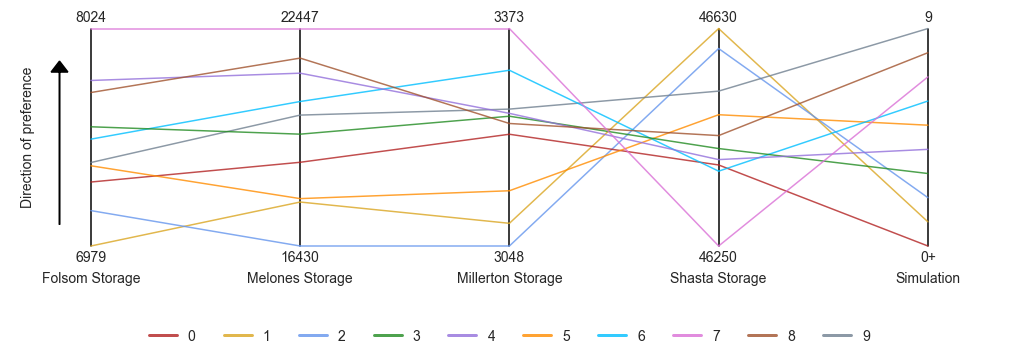

In [125]:
custom_parallel_coordinates(df_metrics_storage, columns_axes=df_metrics_storage.columns,
                            axis_labels = df_metrics_storage.columns,
                            zorder_by=0, ideal_direction='top',
                            alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                            minmaxs=['max','max','max','max','max'],
                            color_by_categorical = "Simulation", color_dict_categorical=color_dict_categorical,
                            save_fig_filename = f'{output_data_dir}/df_metrics_storage.png')

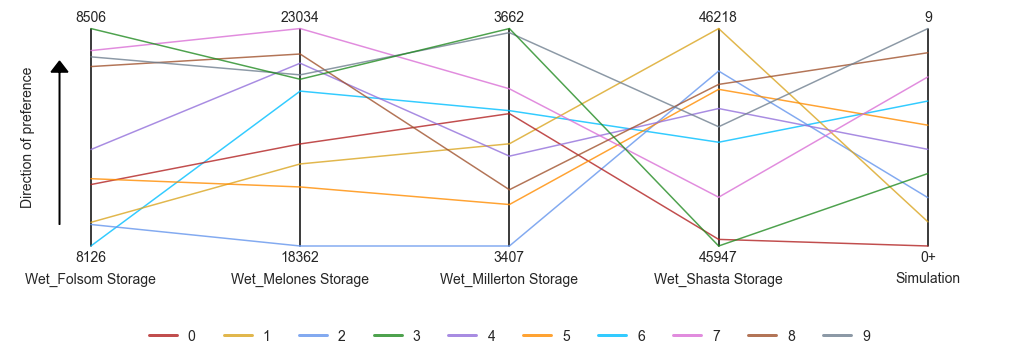

In [126]:
custom_parallel_coordinates(wet_metrics_storage, columns_axes=wet_metrics_storage.columns,
                            axis_labels = wet_metrics_storage.columns,
                            zorder_by=0, ideal_direction='top',
                            alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                            minmaxs=['max','max','max','max','max'],
                            color_by_categorical = "Simulation", color_dict_categorical=color_dict_categorical,
                            save_fig_filename = f'{output_data_dir}/wet_metrics_storage.png')

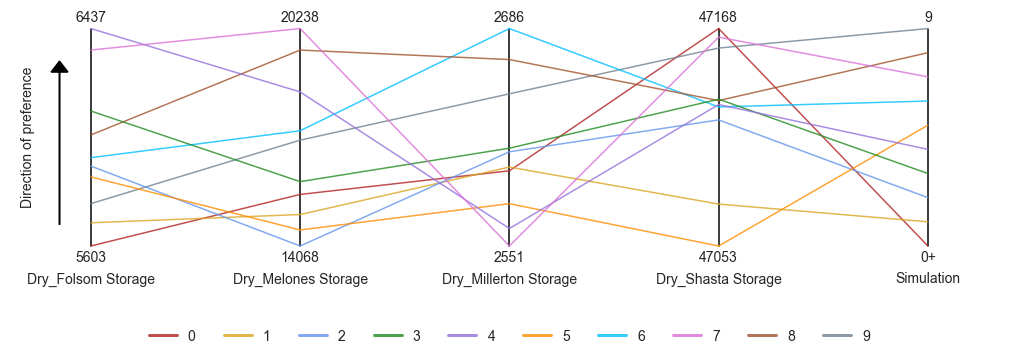

In [127]:
custom_parallel_coordinates(dry_metrics_storage, columns_axes=dry_metrics_storage.columns,
                            axis_labels = dry_metrics_storage.columns,
                            zorder_by=0, ideal_direction='top',
                            alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                            minmaxs=['max','max','max','max','max'],
                            color_by_categorical = "Simulation", color_dict_categorical=color_dict_categorical,
                            save_fig_filename = f'{output_data_dir}/dry_metrics_storage.png')

### Delivery South Variables

In [128]:
df_metrics_delivery_south = df_metrics[['Ann_Avg_CVP_PAG_S', 'Ann_Avg_CVP_PMI_S', 'Ann_Avg_CVP_PRF_S', 'Ann_Avg_CVP_PEX_S', 'Ann_Avg_CVP_TOTAL_S']]
df_metrics_delivery_south["Simulation"] = df_metrics_delivery_south.index

wet_metrics_delivery_south = wet_df_metrics[['Wet_Ann_Avg_CVP_PAG_S', 'Wet_Ann_Avg_CVP_PMI_S', 'Wet_Ann_Avg_CVP_PRF_S', 'Wet_Ann_Avg_CVP_PEX_S', 'Wet_Ann_Avg_CVP_TOTAL_S']]
wet_metrics_delivery_south["Simulation"] = wet_metrics_delivery_south.index

dry_metrics_delivery_south = dry_df_metrics[['Dry_Ann_Avg_CVP_PAG_S', 'Dry_Ann_Avg_CVP_PMI_S', 'Dry_Ann_Avg_CVP_PRF_S', 'Dry_Ann_Avg_CVP_PEX_S', 'Dry_Ann_Avg_CVP_TOTAL_S']]
dry_metrics_delivery_south["Simulation"] = dry_metrics_delivery_south.index

/var/folders/p6/z8ptzv452zz42274h4l4zb4h0000gn/T/ipykernel_59526/474205635.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metrics_delivery_south["Simulation"] = df_metrics_delivery_south.index
/var/folders/p6/z8ptzv452zz42274h4l4zb4h0000gn/T/ipykernel_59526/474205635.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wet_metrics_delivery_south["Simulation"] = wet_metrics_delivery_south.index
/var/folders/p6/z8ptzv452zz42274h4l4zb4h0000gn/T/ipykernel_59526/474205635.py:8: SettingWithCopyWarning: 
A 

In [129]:
df_metrics_delivery_south.columns = ["PAG_S", "PMI_S", "PRF_S", "PEX_S", "TOTAL_S", "Simulation"]
wet_metrics_delivery_south.columns = ["Wet_PAG_S", "Wet_PMI_S", "Wet_PRF_S", "Wet_PEX_S", "Wet_TOTAL_S", "Simulation"]
dry_metrics_delivery_south.columns = ["Dry_PAG_S", "Dry_PMI_S", "Dry_PRF_S", "Dry_PEX_S", "Dry_TOTAL_S", "Simulation"]

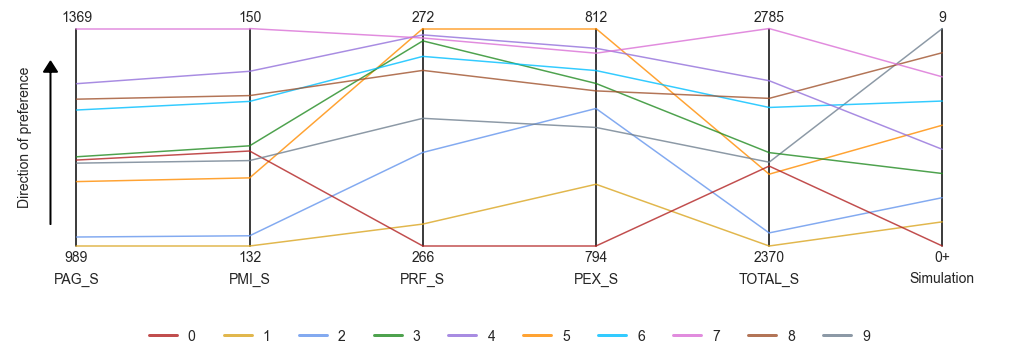

In [131]:
custom_parallel_coordinates(df_metrics_delivery_south, columns_axes=df_metrics_delivery_south.columns,
                            axis_labels = df_metrics_delivery_south.columns,
                            zorder_by=0, ideal_direction='top',
                            alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                            minmaxs=['max','max','max','max','max', "max"],
                            color_by_categorical = "Simulation", color_dict_categorical=color_dict_categorical,
                            save_fig_filename = f'{output_data_dir}/df_metrics_delivery_south.png')

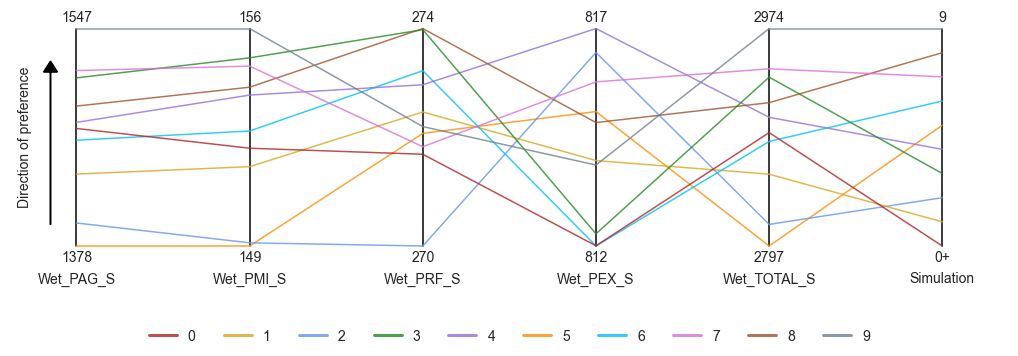

In [132]:
custom_parallel_coordinates(wet_metrics_delivery_south, columns_axes=wet_metrics_delivery_south.columns,
                            axis_labels = wet_metrics_delivery_south.columns,
                            zorder_by=0, ideal_direction='top',
                            alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                            minmaxs=['max','max','max','max','max', "max"],
                            color_by_categorical = "Simulation", color_dict_categorical=color_dict_categorical,
                            save_fig_filename = f'{output_data_dir}/wet_metrics_delivery_south.png')

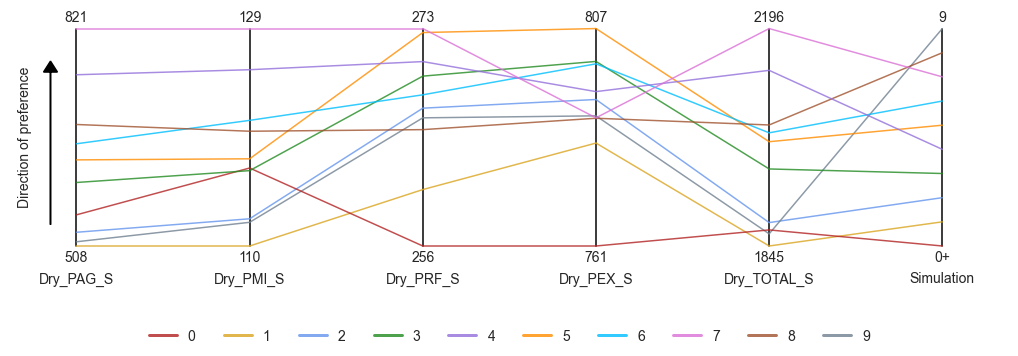

In [133]:
custom_parallel_coordinates(dry_metrics_delivery_south, columns_axes=dry_metrics_delivery_south.columns,
                            axis_labels = dry_metrics_delivery_south.columns,
                            zorder_by=0, ideal_direction='top',
                            alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                            minmaxs=['max','max','max','max','max', "max"],
                            color_by_categorical = "Simulation", color_dict_categorical=color_dict_categorical,
                            save_fig_filename = f'{output_data_dir}/dry_metrics_delivery_south.png')

### Delivery North Variables

In [134]:
df_metrics_delivery_north = df_metrics[['Ann_Avg_CVP_PAG_N', 'Ann_Avg_CVP_PMI_N', 'Ann_Avg_CVP_PRF_N', 'Ann_Avg_CVP_PSC_N', 'Ann_Avg_CVP_TOTAL_N']]
df_metrics_delivery_north["Simulation"] = df_metrics_delivery_north.index

wet_metrics_delivery_north = wet_df_metrics[['Wet_Ann_Avg_CVP_PAG_N', 'Wet_Ann_Avg_CVP_PMI_N', 'Wet_Ann_Avg_CVP_PRF_N', 'Wet_Ann_Avg_CVP_PSC_N', 'Wet_Ann_Avg_CVP_TOTAL_N']]
wet_metrics_delivery_north["Simulation"] = wet_metrics_delivery_north.index

dry_metrics_delivery_north = dry_df_metrics[['Dry_Ann_Avg_CVP_PAG_N', 'Dry_Ann_Avg_CVP_PMI_N', 'Dry_Ann_Avg_CVP_PRF_N', 'Dry_Ann_Avg_CVP_PSC_N', 'Dry_Ann_Avg_CVP_TOTAL_N']]
dry_metrics_delivery_north["Simulation"] = dry_metrics_delivery_north.index

/var/folders/p6/z8ptzv452zz42274h4l4zb4h0000gn/T/ipykernel_59526/3245226632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metrics_delivery_north["Simulation"] = df_metrics_delivery_north.index
/var/folders/p6/z8ptzv452zz42274h4l4zb4h0000gn/T/ipykernel_59526/3245226632.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wet_metrics_delivery_north["Simulation"] = wet_metrics_delivery_north.index
/var/folders/p6/z8ptzv452zz42274h4l4zb4h0000gn/T/ipykernel_59526/3245226632.py:8: SettingWithCopyWarning: 

In [135]:
df_metrics_delivery_north.columns = ["PAG_N", "PMI_N", "PRF_N", "PSC_N", "TOTAL_N", "Simulation"]
wet_metrics_delivery_north.columns = ["Wet_PAG_N", "Wet_PMI_N", "Wet_PRF_N", "Wet_PSC_N", "Wet_TOTAL_N", "Simulation"]
dry_metrics_delivery_north.columns = ["Dry_PAG_N", "Dry_PMI_N", "Dry_PRF_N", "Dry_PSC_N", "Dry_TOTAL_N", "Simulation"]

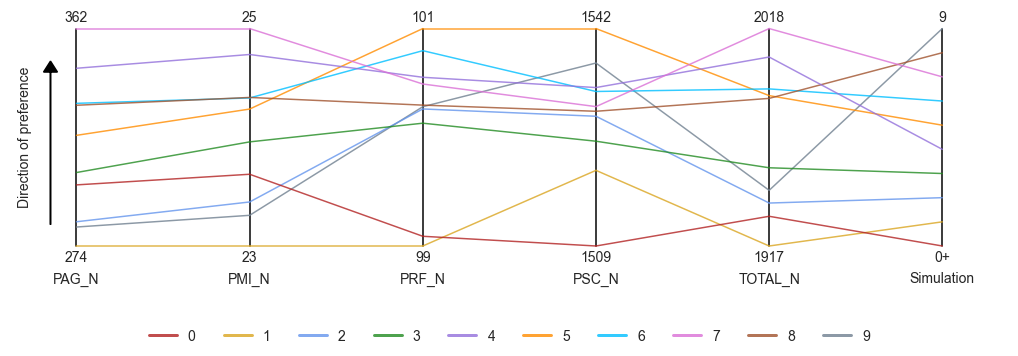

In [136]:
custom_parallel_coordinates(df_metrics_delivery_north, columns_axes=df_metrics_delivery_north.columns,
                            axis_labels = df_metrics_delivery_north.columns,
                            zorder_by=0, ideal_direction='top',
                            alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                            minmaxs=['max','max','max','max','max', "max"],
                            color_by_categorical = "Simulation", color_dict_categorical=color_dict_categorical,
                            save_fig_filename = f'{output_data_dir}/df_metrics_delivery_north.png')

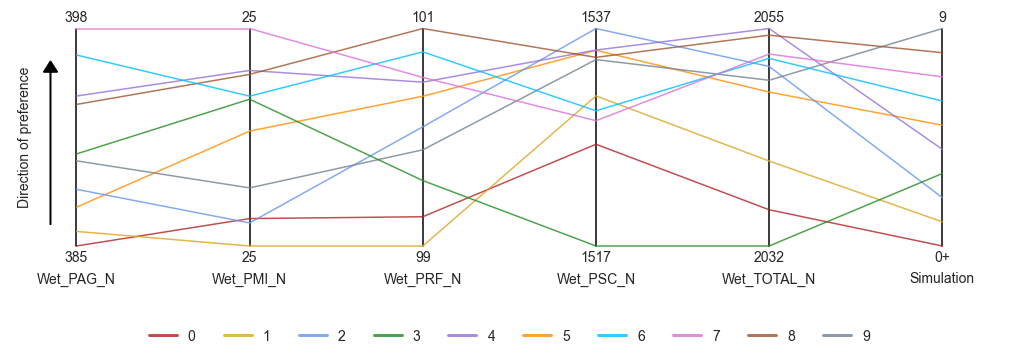

In [137]:
custom_parallel_coordinates(wet_metrics_delivery_north, columns_axes=wet_metrics_delivery_north.columns,
                            axis_labels = wet_metrics_delivery_north.columns,
                            zorder_by=0, ideal_direction='top',
                            alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                            minmaxs=['max','max','max','max','max', "max"],
                            color_by_categorical = "Simulation", color_dict_categorical=color_dict_categorical,
                            save_fig_filename = f'{output_data_dir}/wet_metrics_delivery_north.png')

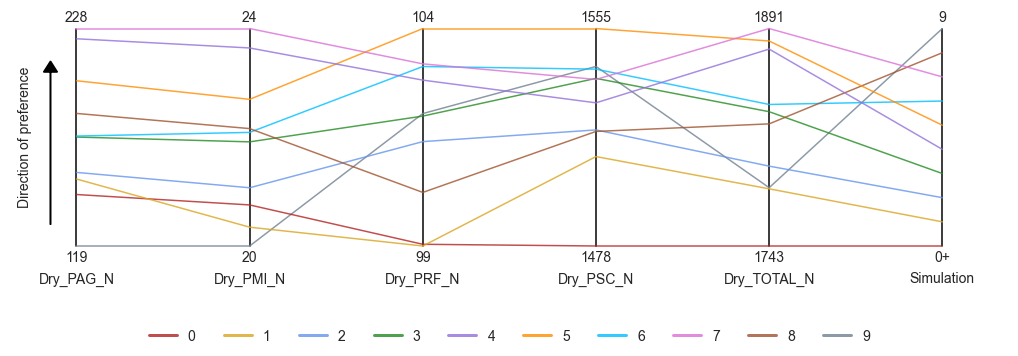

In [138]:
custom_parallel_coordinates(dry_metrics_delivery_north, columns_axes=dry_metrics_delivery_north.columns,
                            axis_labels = dry_metrics_delivery_north.columns,
                            zorder_by=0, ideal_direction='top',
                            alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                            minmaxs=['max','max','max','max','max', "max"],
                            color_by_categorical = "Simulation", color_dict_categorical=color_dict_categorical,
                            save_fig_filename = f'{output_data_dir}/dry_metrics_delivery_north.png')

### SWP + Rest

In [139]:
df_metrics_swp_ndo = df_metrics[['Ann_Avg_SWP_MWD', 'Ann_Avg_SWP_PAG', 'Ann_Avg_SWP_PMI', 'Ann_Avg_NDO']]
df_metrics_swp_ndo["Simulation"] = df_metrics_swp_ndo.index

wet_metrics_swp_ndo = wet_df_metrics[['Wet_Ann_Avg_SWP_MWD', 'Wet_Ann_Avg_SWP_PAG', 'Wet_Ann_Avg_SWP_PMI', "Wet_Ann_Avg_NDO"]]
wet_metrics_swp_ndo["Simulation"] = wet_metrics_swp_ndo.index

dry_metrics_swp_ndo = dry_df_metrics[['Dry_Ann_Avg_SWP_MWD', 'Dry_Ann_Avg_SWP_PAG', 'Dry_Ann_Avg_SWP_PMI', "Dry_Ann_Avg_NDO"]]
dry_metrics_swp_ndo["Simulation"] = dry_metrics_swp_ndo.index

/var/folders/p6/z8ptzv452zz42274h4l4zb4h0000gn/T/ipykernel_59526/3402548934.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metrics_swp_ndo["Simulation"] = df_metrics_swp_ndo.index
/var/folders/p6/z8ptzv452zz42274h4l4zb4h0000gn/T/ipykernel_59526/3402548934.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wet_metrics_swp_ndo["Simulation"] = wet_metrics_swp_ndo.index
/var/folders/p6/z8ptzv452zz42274h4l4zb4h0000gn/T/ipykernel_59526/3402548934.py:8: SettingWithCopyWarning: 
A value is trying to be set

In [140]:
df_metrics_swp_ndo.columns = ["SWP_MWD", "SWP_PAG", "SWP_PMI", "NDO", "Simulation"]
wet_metrics_swp_ndo.columns = ["Wet_SWP_MWD", "Wet_SWP_PAG", "Wet_SWP_PMI", "Wet_NDO", "Simulation"]
dry_metrics_swp_ndo.columns = ["Dry_SWP_MWD", "Dry_SWP_PAG", "Dry_SWP_PMI", "Dry_NDO", "Simulation"]

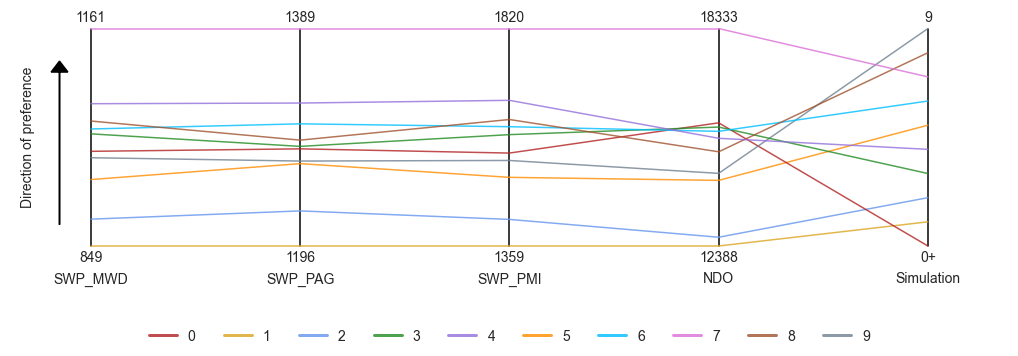

In [141]:
custom_parallel_coordinates(df_metrics_swp_ndo, columns_axes=df_metrics_swp_ndo.columns,
                            axis_labels = df_metrics_swp_ndo.columns,
                            zorder_by=0, ideal_direction='top',
                            alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                            minmaxs=['max','max','max','max','max'],
                            color_by_categorical = "Simulation", color_dict_categorical=color_dict_categorical,
                            save_fig_filename = f'{output_data_dir}/df_metrics_swp_ndo.png')

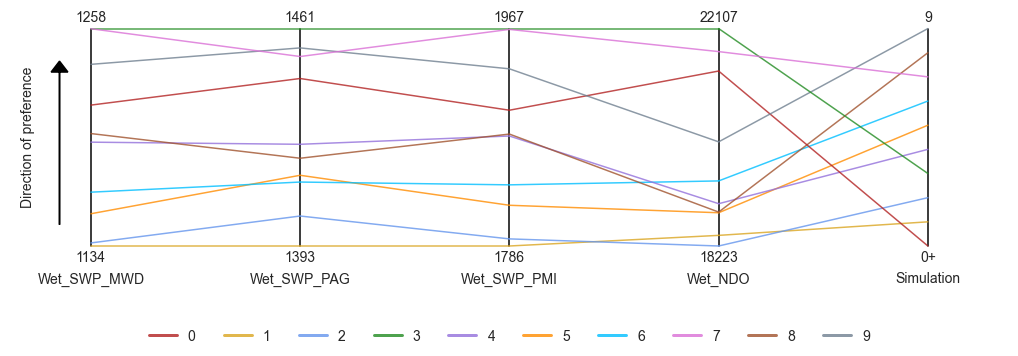

In [142]:
custom_parallel_coordinates(wet_metrics_swp_ndo, columns_axes=wet_metrics_swp_ndo.columns,
                            axis_labels = wet_metrics_swp_ndo.columns,
                            zorder_by=0, ideal_direction='top',
                            alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                            minmaxs=['max','max','max','max','max'],
                            color_by_categorical = "Simulation", color_dict_categorical=color_dict_categorical,
                            save_fig_filename = f'{output_data_dir}/wet_metrics_swp_ndo.png')

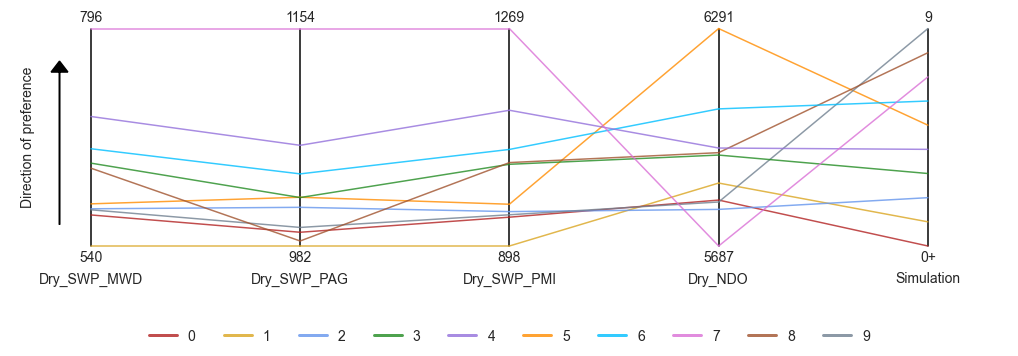

In [143]:
custom_parallel_coordinates(dry_metrics_swp_ndo, columns_axes=dry_metrics_swp_ndo.columns,
                            axis_labels = dry_metrics_swp_ndo.columns,
                            zorder_by=0, ideal_direction='top',
                            alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                            minmaxs=['max','max','max','max','max'],
                            color_by_categorical = "Simulation", color_dict_categorical=color_dict_categorical,
                            save_fig_filename = f'{output_data_dir}/dry_metrics_swp_ndo.png')

### Salmon Use Case - Shasta > 3.8 MAF

In [144]:
def count_exceedance_days(data, threshold):
    exceedance_counts = pd.DataFrame(np.nan, index=[0], columns=data.columns)

    for col in data.columns:
        exceedance_counts.loc[0, col] = (data[col] > threshold).sum()
    return exceedance_counts

In [145]:
def exceedance_probability(df, var, threshold, month, vartitle):
    var_df = create_subset_var(df, var)
    var_month_df = var_df[var_df.index.month.isin([month])]
    result_df = count_exceedance_days(var_month_df, threshold) / len(var_month_df) * 100
    reshaped_df = result_df.melt(value_name=vartitle).reset_index(drop=True)[[vartitle]]
    return reshaped_df

In [146]:
Apr_Prob_SHSTAgt38 = exceedance_probability(df, "S_SHSTA_", 3800, 4, "Apr_Prob_SHSTAgt38")
Apr_Prob_SHSTAgt38

,Apr_Prob_SHSTAgt38
0,75.0
1,67.0
2,73.0
3,75.0
4,88.0
5,82.0
6,84.0
7,92.0
8,83.0
9,70.0


In [147]:
temp_dfs = [] 

for wet_df_name in df_wet_names:
    wet_df = globals()[wet_df_name]
    exceedance_result = exceedance_probability(wet_df, "S_SHSTA_", 3800, 4, "temp")
    probability_value = exceedance_result.iloc[0, 0] 
    temp_df = pd.DataFrame({"Wet_Apr_Prob_SHSTAgt38": [probability_value]})  
    temp_dfs.append(temp_df)

Wet_Apr_Prob_SHSTAgt38 = pd.concat(temp_dfs, ignore_index=True)
Wet_Apr_Prob_SHSTAgt38

,Wet_Apr_Prob_SHSTAgt38
0,98.437500
1,94.230769
2,100.000000
3,100.000000
4,100.000000
5,98.412698
6,100.000000
7,100.000000
8,98.571429
9,98.333333


In [148]:
temp_dfs = []

for dry_df_name in df_dry_names:
    dry_df = globals()[dry_df_name]
    exceedance_result = exceedance_probability(dry_df, "S_SHSTA_", 3800, 4, "temp")
    probability_value = exceedance_result.iloc[0, 0]
    temp_df = pd.DataFrame({"Dry_Apr_Prob_SHSTAgt38": [probability_value]})
    temp_dfs.append(temp_df)

Dry_Apr_Prob_SHSTAgt38 = pd.concat(temp_dfs, ignore_index=True)
Dry_Apr_Prob_SHSTAgt38

,Dry_Apr_Prob_SHSTAgt38
0,33.333333
1,37.500000
2,40.000000
3,37.500000
4,57.142857
5,54.054054
6,44.827586
7,61.904762
8,46.666667
9,27.500000
